# SMS SPAM DETECTOR 🕵

Allo scopo di realizzare un classificatore che sia in grado di rilevare se un certo messaggio sia spam o meno, abbiamo strutturato questo notebook non addestrando un unico classificatore con un solo tipo di Text Preprocessing, bensì testando diversi approcci e algoritmi di classificazione, così da confrontare le diverse soluzioni.
 
 
- Dapprima abbiamo effettuato l'import dei dati (sezione ***1. Import dei dati***), effettuandone un'analisi descrittiva. 

- Dopodichè, abbiamo voluto testare la **lemmatization** prima e lo **stemming** poi, per effettuare il Text Preprocesing (sezione ***2. Text Preprocessing Lemmatization*** e sezione ***3. Text Preprocessing - Stemming***).
 
- In queste due sezioni (sezione 2 e 3), addestriamo 5 differenti algoritmi - *Dummy Classifier, MultinomialNB*, *Support Vector Machine*, *Decision Tree* e *Logistic Regression* - utilizzando due strategie di ***feature extraction*** diverse, ovvero *Bag of words* (***CountVectorizer***) e *TF-IDF* (***TfidfVectorizer***), ottendendo in questo modo ben **20 classificatori**.

- Nella penultima sezione (sezione ***4. Accuracy dei 20 classificatori***) abbiamo deciso di raccogliere le accuracy di tutti i classificatori addestrati per confrontare le loro performance.

- Infine, abbiamo implementato una **Strategia di Hardvoting** (sezione ***5. Gestione dello sbilanciamento tra classi***) addestrando 7 classificatori su dataset con classi bilanciate. Combinando i vari esiti, il risultato più restituito sarà quello finale.

# 1. Import dei dati

In [32]:
# Utilizziamo la funzione definita nel modulo 'conversion' - da noi creato - per ottenere il file '.csv'
from conversion import arff_to_csv

df = arff_to_csv(
    url = "https://storm.cis.fordham.edu/~gweiss/data-mining/weka-data/sms-spam-dataset.arff",
    columns = ['Text', 'Class'],
    name_csv = 'spam_det.csv')

# Visualizza le prime righe del DataFrame
df.head()

,Text,Class
0,'Go until jurong point crazy.. Available only ...,ham
1,'Ok lar... Joking wif u oni...',ham
2,'Free entry in 2 a wkly comp to win FA Cup fin...,spam
3,'U dun say so early hor... U c already then sa...,ham
4,'Nah I dont think he goes to usf he lives arou...,ham


In [66]:
# Altro esempio per vedere la nostra funzione in azione

'''data = arff_to_csv(url = "https://storm.cis.fordham.edu/~gweiss/data-mining/weka-data/iris.arff",
            columns = ['sepallength', 'sepalwidth', 'petallength', 'petalwidth', 'class'],
            name_csv = 'iris_data.csv')

data'''

'data = arff_to_csv(url = "https://storm.cis.fordham.edu/~gweiss/data-mining/weka-data/iris.arff",\n            columns = [\'sepallength\', \'sepalwidth\', \'petallength\', \'petalwidth\', \'class\'],\n            name_csv = \'iris_data.csv\')\n\ndata'

## 1.1 Analisi Descrittiva di 'spam_det.csv'

In [67]:
# Vediamo quanti valori abbiamo per ciascuna label
df['Class'].value_counts()

Class
ham     4825
spam     747
Name: count, dtype: int64

In [33]:
# Salviamo il numero di ham e il numero di spam per usare
# tali valori in operazioni successive

n_ham, n_spam = df['Class'].value_counts()
print("Numero di SMS 'ham' : " + str(n_ham))
print("Numero di SMS 'spam': " + str(n_spam))

Numero di SMS 'ham' : 4825
Numero di SMS 'spam': 747


### 1.1.1 Barplot per le Classi

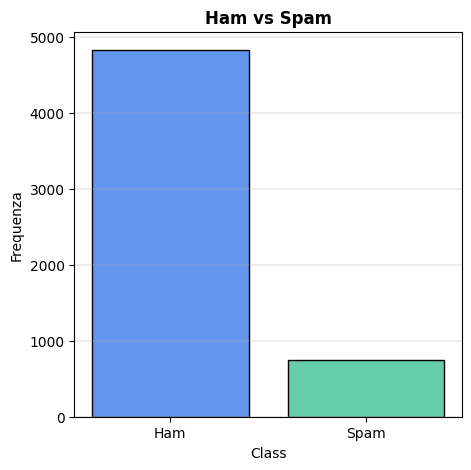

In [69]:
# Creiamo un barplot per visualizzare il numero di ham e spam
import matplotlib.pyplot as plt


plt.figure(figsize = (5, 5))

plt.bar(x = ['Ham', 'Spam'],
        height = [n_ham, n_spam],
        color = ['cornflowerblue', 'mediumaquamarine'],
        edgecolor = 'black')

plt.grid(axis = 'y',
         linewidth = 0.3)

plt.title('Ham vs Spam',
          fontweight = 'bold')

plt.ylabel('Frequenza')
plt.xlabel('Class')
plt.show()

### Dividiamo il dataset per separare gli Ham dagli Spam

In [34]:
# Creiamo due liste contenenti i messaggi di Ham e di Spam
ham_msg = []
spam_msg = []

for i in range(len(df)):
    if df.loc[i]['Class'] == 'ham':

        # Rimuoviamo anche gli apici all'inizio e alla fine della stringa
        ham_msg.append(df.loc[i]['Text'].strip("'"))

    else:
        spam_msg.append(df.loc[i]['Text'].strip("'"))



# Verifichiamo che il procedimanto sia corretto vedendo la lunghezza delle liste
print('Numero Ham: ' + str(len(ham_msg)))
print('Numero Spam: ' + str(len(spam_msg)))

Numero Ham: 4825
Numero Spam: 747


### 1.1.2 Calcoliamo la lunghezza media (in caratteri) dei messaggi per entrambe le Classi

### Messaggi Ham

In [71]:
# Calcoliamo la lunghezza media di caratteri per i messaggi Ham
total_length_ham_msg = 0

# Questa lista conterrà le lunghezze di ogni stringa (in caratteri)
len_each_ham_text = []

for t in ham_msg:
    total_length_ham_msg += len(t)
    len_each_ham_text.append(len(t))



# Calcoliamo la media 
mean_len_ham = total_length_ham_msg / (len(ham_msg))
print('Numero medio di caratteri per i messaggi Ham: ' + str(mean_len_ham))

Numero medio di caratteri per i messaggi Ham: 70.23730569948187


In [72]:
# Vediamo la lunghezza minima per i messaggi di Ham e quella massima
 
print(f'Il messaggio di Ham più lungo ha {max(len_each_ham_text)} caratteri.\n')
print(f'Il messaggio di Ham più breve ha {min(len_each_ham_text)} caratteri.')

Il messaggio di Ham più lungo ha 909 caratteri.

Il messaggio di Ham più breve ha 2 caratteri.


In [73]:
# Calcoliamo la mediana dei messaggi di Ham in caratteri
from numpy import median

median_ham_char = median(len_each_ham_text)
print(f'La mediana per la lunghezza in caratteri per i messaggi di Ham è {median_ham_char}')

La mediana per la lunghezza in caratteri per i messaggi di Ham è 52.0


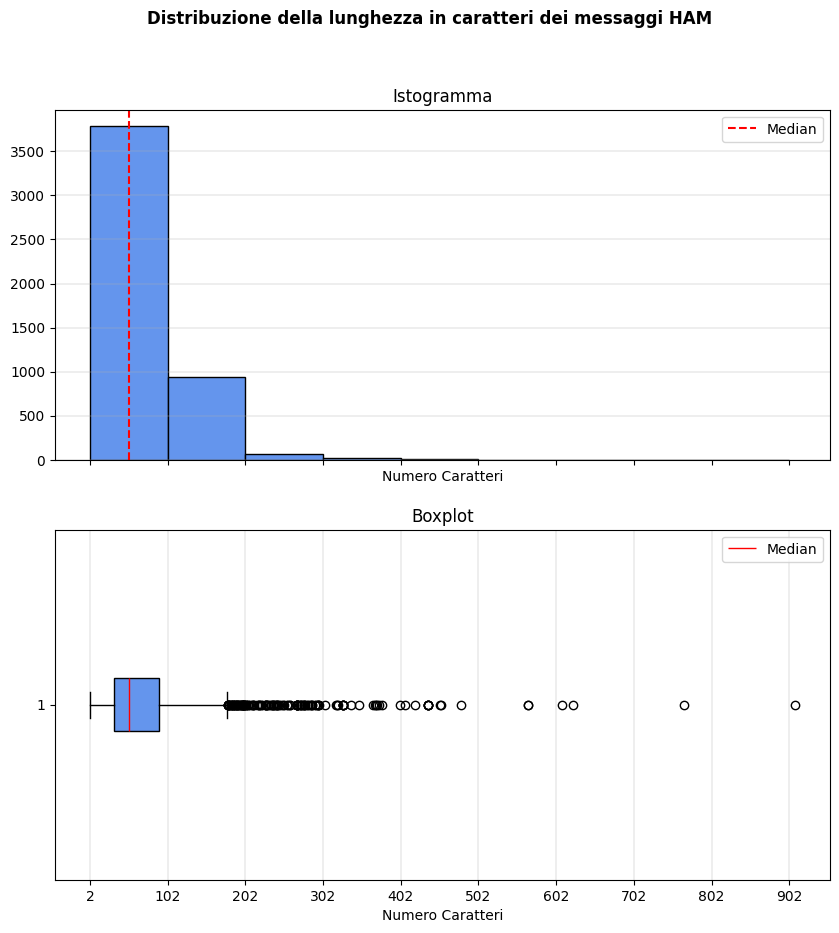

In [74]:
from numpy import median

# ampiezza delle classi 
bin_width = 100

# Istogramma
figure, (ax1, ax2) = plt.subplots(2, 1, figsize = (10,10), sharex = True)
figure.suptitle('Distribuzione della lunghezza in caratteri dei messaggi HAM', fontweight='bold')


ax1.hist(len_each_ham_text, bins=range(2, 1000, bin_width), edgecolor='black', color= 'cornflowerblue')
ax1.axvline(median_ham_char, ls = '--', color = 'red', label='Median')
ax1.legend()
ax1.grid(axis='y', linewidth= 0.3)
ax1.set_title('Istogramma')
ax1.set_xlabel('Numero Caratteri')


box = ax2.boxplot(len_each_ham_text, 
                  vert=False, 
                  patch_artist=True, 
                  medianprops={'color':'red', 'label':'Median'},
                  )
for patch in box['boxes']:
    patch.set_facecolor('cornflowerblue')
ax2.set_xticks(ticks = range(2, 1000, bin_width))
ax2.legend()
ax2.set_xlabel('Numero Caratteri')
ax2.set_title('Boxplot')
ax2.grid(axis='x', linewidth=0.3)


### Messaggi Spam

In [75]:
# Calcoliamo la lunghezza media di caratteri per i messaggi Spam
total_length_spam_msg = 0

# Questa lista conterrà le lunghezze di ogni stringa (in caratteri)
len_each_spam_text = []

for t in spam_msg:
    total_length_spam_msg += len(t)
    len_each_spam_text.append(len(t))

# Calcoliamo la media 
mean_len_spam = total_length_spam_msg / (len(spam_msg))
print('Numero medio di caratteri per i messaggi Spam: ' + str(mean_len_spam))

Numero medio di caratteri per i messaggi Spam: 138.09638554216866


In [76]:
# Vediamo la lunghezza minima per i messaggi di Spam e quella massima
 
print(f'Il messaggio di Spam più lungo ha {max(len_each_spam_text)} caratteri.\n')
print(f'Il messaggio di Spam più breve ha {min(len_each_spam_text)} caratteri.')

Il messaggio di Spam più lungo ha 223 caratteri.

Il messaggio di Spam più breve ha 13 caratteri.


In [77]:
# Calcoliamo la mediana dei messaggi di Spam in caratteri
from numpy import median

median_spam_char = median(len_each_spam_text)
print(f'La mediana per la lunghezza in caratteri per i messaggi di Spam è {median_spam_char}')

La mediana per la lunghezza in caratteri per i messaggi di Spam è 149.0


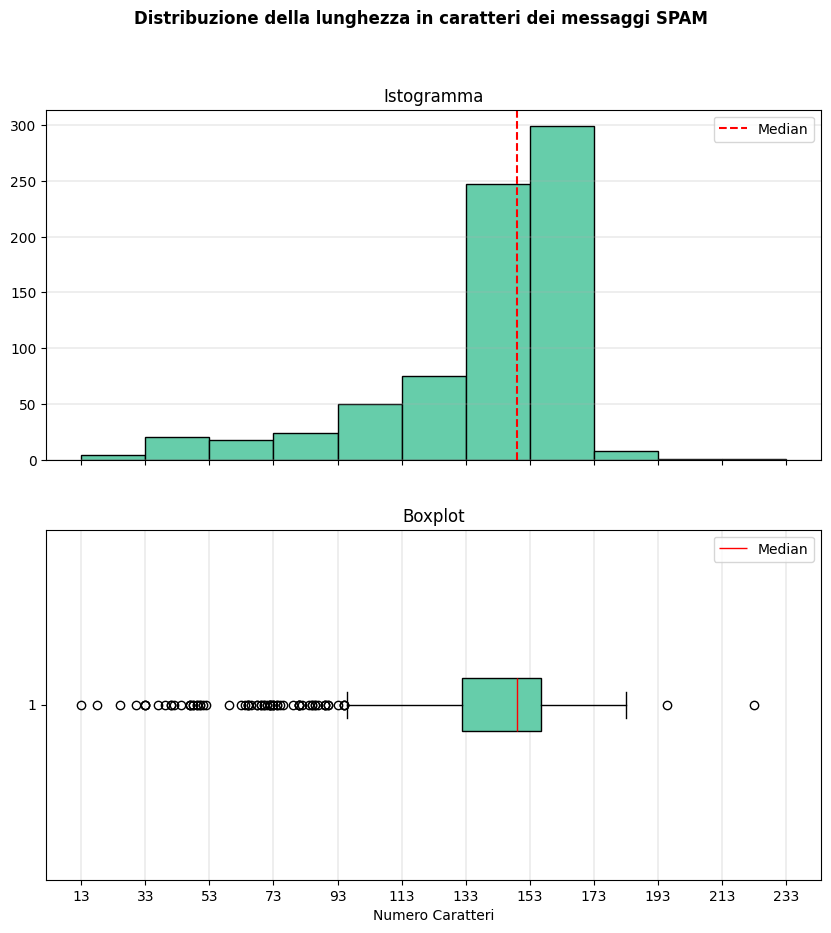

In [78]:
from numpy import median

# ampiezza delle classi 
bin_width = 20

# Istogramma
figure, (ax1, ax2) = plt.subplots(2, 1, figsize = (10,10), sharex = True)
figure.suptitle('Distribuzione della lunghezza in caratteri dei messaggi SPAM', fontweight='bold')


ax1.hist(len_each_spam_text, bins=range(13, 250, bin_width), edgecolor='black', color= 'mediumaquamarine')
ax1.axvline(median_spam_char, ls = '--', color = 'red', label='Median')
ax1.legend()
#ax1.set_xticks(ticks = range(13, 250, bin_width))
ax1.grid(axis='y', linewidth= 0.3)
ax1.set_title('Istogramma')


box = ax2.boxplot(len_each_spam_text,
                  vert=False,
                  patch_artist=True,
                  medianprops={'color':'red', 'label':'Median'})
for patch in box['boxes']:
    patch.set_facecolor('mediumaquamarine')
ax2.set_xticks(ticks = range(13, 250, bin_width))
ax2.set_xlabel('Numero Caratteri')
ax2.set_title('Boxplot')
ax2.legend()
ax2.grid(axis='x', linewidth=0.3)

### 1.1.3 Calcoliamo la lunghezza media (in parole) dei messaggi per entrambe le Classi

### Messaggi Ham

In [79]:
# Calcoliamo la media di parole per i messaggi Ham
import re

# Tale variabile conterrà il numero totale di parole della lista ham_msg
num_ham_words = 0
len_words_ham = []
for m in ham_msg:
    # Rimuoviamo i caratteri speciali da ogni messaggio m
    m = re.sub('[^a-zA-Z]', ' ', m)
    
    # Dividiamo m in sigole parole, ottenendo una lista di parole
    words = m.split()

    # Contiamo il numero di parole del singolo messaggio -> len(words)
    num_ham_words += len(words)

    # Salviamo la lunghezza in parloe del singolo messaggio
    len_words_ham.append(len(words))



# Calcoliamo la media di parole
mean_words_ham = num_ham_words / len(ham_msg)
print('Numero medio di parole per i messaggi Ham: ' + str(mean_words_ham))


Numero medio di parole per i messaggi Ham: 14.09119170984456


In [80]:
# Vediamo la lunghezza minima di parole per i messaggi di Ham e quella massima
 
print(f'Il messaggio di Ham più lungo ha {max(len_words_ham)} parole.\n')
print(f'Il messaggio di Ham più breve ha {min(len_words_ham)} parole.')

Il messaggio di Ham più lungo ha 189 parole.

Il messaggio di Ham più breve ha 0 parole.


In [81]:
# Calcoliamo la mediana dei messaggi di Ham in parole
from numpy import median

median_ham_words = median(len_words_ham)
print(f'La mediana per la lunghezza in parole per i messaggi di Ham è {median_ham_words}')

La mediana per la lunghezza in parole per i messaggi di Ham è 10.0


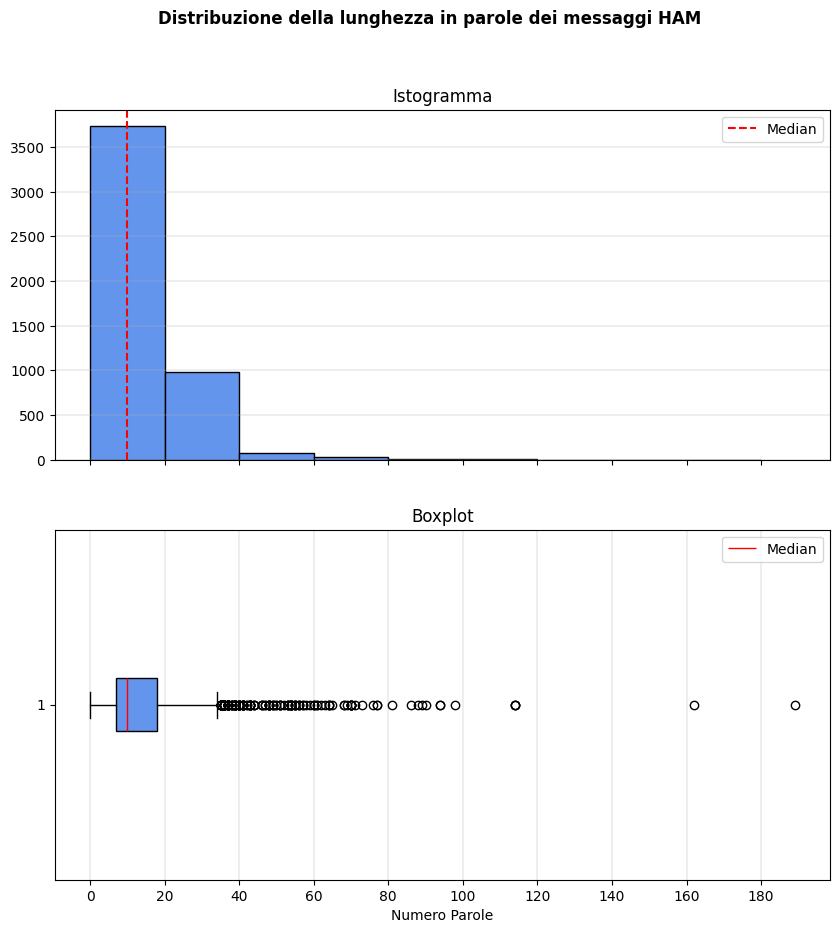

In [82]:
from numpy import median

# ampiezza delle classi 
bin_width = 20

# Istogramma
figure, (ax1, ax2) = plt.subplots(2, 1, figsize = (10,10), sharex = True)
figure.suptitle('Distribuzione della lunghezza in parole dei messaggi HAM', fontweight='bold')


ax1.hist(len_words_ham, bins=range(0, 200, bin_width), edgecolor='black', color= 'cornflowerblue')
ax1.axvline(median_ham_words, ls = '--', color = 'red', label='Median')
ax1.legend()
ax1.grid(axis='y', linewidth= 0.3)
ax1.set_title('Istogramma')


box = ax2.boxplot(len_words_ham,
                  vert=False,
                  patch_artist=True,
                  medianprops={'color':'red', 'label':'Median'})
for patch in box['boxes']:
    patch.set_facecolor('cornflowerblue')
ax2.set_xticks(ticks = range(0, 200, bin_width))
ax2.set_xlabel('Numero Parole')
ax2.set_title('Boxplot')
ax2.legend()
ax2.grid(axis='x', linewidth=0.3)

### Messaggi Spam

In [83]:
# Calcoliamo la media di parole per i messaggi Spam
import re

# Tale variabile conterrà il numero totale di parole della lista spam_msg
num_spam_words = 0

len_words_spam = []

for m in spam_msg:
    # Rimuoviamo i caratteri speciali da ogni messaggio m
    m = re.sub('[^a-zA-Z]', ' ', m)
    
    # Dividiamo m in sigole parole, ottenendo una lista di parole
    words = m.split()

    # Contiamo il numero di parole del singolo messaggio -> len(words)
    num_spam_words += len(words)

    # Salviamo la lunghezza in parloe del singolo messaggio
    len_words_spam.append(len(words))



# Calcoliamo la media di parole
mean_words_spam = num_spam_words / len(spam_msg)
print('Numero medio di parole per i messaggi Spam: ' + str(mean_words_spam))

Numero medio di parole per i messaggi Spam: 22.812583668005356


In [84]:
# Vediamo la lunghezza minima di parole per i messaggi di Spam e quella massima
 
print(f'Il messaggio di Spam più lungo ha {max(len_words_spam)} parole.\n')
print(f'Il messaggio di Spam più breve ha {min(len_words_spam)} parole.')

Il messaggio di Spam più lungo ha 34 parole.

Il messaggio di Spam più breve ha 1 parole.


In [85]:
# Calcoliamo la mediana dei messaggi di Spam in parole
from numpy import median

median_spam_words = median(len_words_spam)
print(f'La mediana per la lunghezza in parole per i messaggi di Spam è {median_spam_words}')

La mediana per la lunghezza in parole per i messaggi di Spam è 24.0


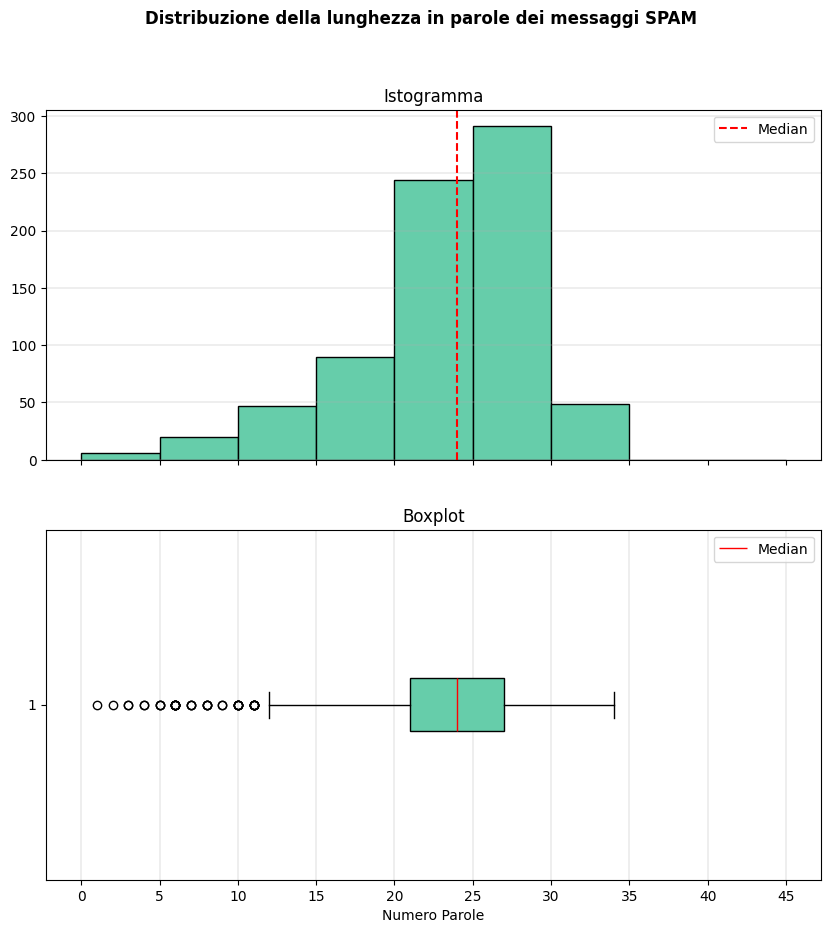

In [86]:
from numpy import median

# ampiezza delle classi 
bin_width = 5

# Istogramma
figure, (ax1, ax2) = plt.subplots(2, 1, figsize = (10,10), sharex = True)
figure.suptitle('Distribuzione della lunghezza in parole dei messaggi SPAM', fontweight='bold')


ax1.hist(len_words_spam, bins=range(0, 50, bin_width), edgecolor='black', color= 'mediumaquamarine')
ax1.axvline(median_spam_words, ls = '--', color = 'red', label='Median')
ax1.legend()
ax1.grid(axis='y', linewidth= 0.3)
ax1.set_title('Istogramma')


box = ax2.boxplot(len_words_spam,
                  vert=False,
                  patch_artist=True,
                  medianprops={'color':'red', 'label':'Median'})
for patch in box['boxes']:
    patch.set_facecolor('mediumaquamarine')
ax2.set_xticks(ticks = range(0, 50, bin_width))
ax2.set_xlabel('Numero Parole')
ax2.set_title('Boxplot')
ax2.legend()
ax2.grid(axis='x', linewidth=0.3)

### 1.1.4 Barplot per le lunghezze medie in caratteri e in parole dei messaggi

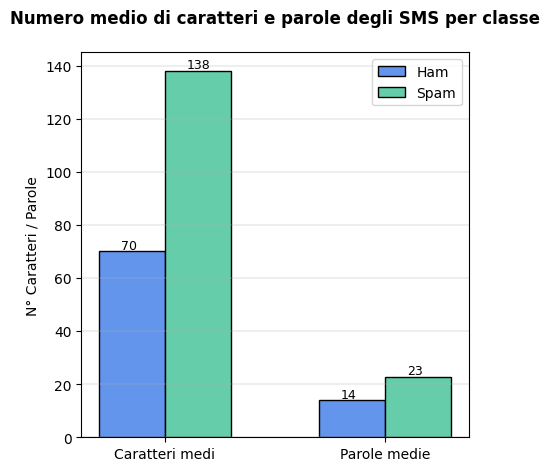

In [87]:
import matplotlib.pyplot as plt

# Definiamo i numeri da porre sulle barre e le relative posizioni 
y_pos = [mean_len_ham, mean_len_spam, mean_words_ham, mean_words_spam]
num_on_top = [str(round(mean_len_ham)),
              str(round(mean_len_spam)), 
              str(round(mean_words_ham)), 
              str(round(mean_words_spam))]
x_pos = [0, 0.3, 1, 1.3]


# Creiamo i barplot
plt.figure(figsize=(5, 5))

plt.bar(x = [0, 1],
        height=[mean_len_ham, mean_words_ham],
        width = 0.3,
        label = 'Ham',
        color = ['cornflowerblue', 'cornflowerblue'],
        edgecolor='black')

plt.bar(x = [0.3, 1.3],
        height=[mean_len_spam, mean_words_spam],
        width = 0.3,
        label = 'Spam',
        color = ['mediumaquamarine', 'mediumaquamarine'],
        edgecolor='black')


# Poniamo i valori medi e mediani sulle barre
for i in range(0, 4):
        plt.text(x = x_pos[i] - 0.05,
                 y = y_pos[i] + 0.8,
                 s = num_on_top[i],
                 size = 9)

plt.legend()
plt.grid(axis= 'y', linewidth = 0.3)
plt.xticks(ticks=[0.15, 1.15],labels=['Caratteri medi', 'Parole medie'])

plt.title('Numero medio di caratteri e parole degli SMS per classe\n', 
          fontweight = 'bold')

plt.ylabel('N° Caratteri / Parole')

plt.show()

### 1.1.5 WordCloud dei messaggi suddivisi per Classe

### WordCloud per i messaggi di Ham

In [5]:
from nltk.corpus import stopwords

import re

# Tale variabile conterrà tutte le parole della lista ham_msg in un'unica stringa
ham_words = ''

for m in ham_msg:
    # Rimuoviamo i caratteri speciali da ogni messaggio m
    m = re.sub('[^a-zA-Z]', ' ', m)
    
    # Dividiamo m in sigole parole, ottenendo una lista di parole
    words = m.split()
   
    # Rimuoviamo le stopwords
    words = [word for word in words if word not in stopwords.words('english')]
    
    # Uniamo le parole intervallandole con uno spazio
    words = ' '.join(words)

    # Aggiungiamo la stringa words alla stringa ham_words
    ham_words += words

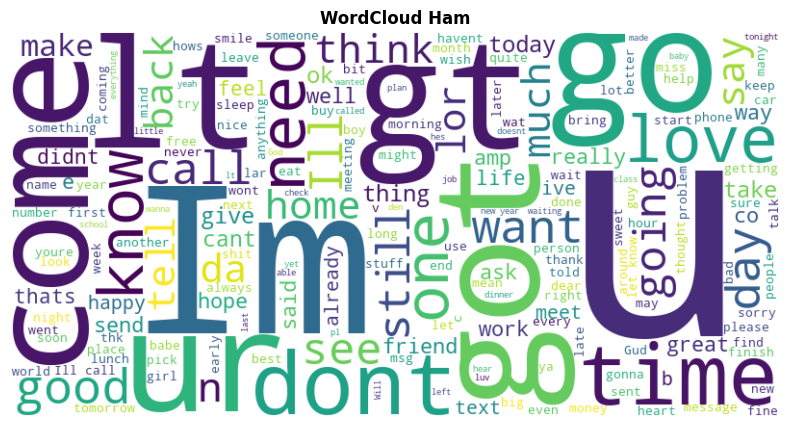

In [6]:
# Creazione della word cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Creiamo la wordcloud dalla stringa 'ham_words' che contiene tutte le parole dei messaggi Ham
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(ham_words)


# Visualizzazione della word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Ham', fontweight= 'bold')
plt.show()

### WordCloud per i messaggi di Spam

In [7]:
from nltk.corpus import stopwords
import re

# Tale variabile conterrà tutte le parole della lista spam_msg in un'unica stringa
spam_words = ''

for m in spam_msg:
    # Rimuoviamo i caratteri speciali da ogni messaggio m
    m = re.sub('[^a-zA-Z]', ' ', m)
    
    # Dividiamo m in sigole parole, ottenendo una lista di parole
    words = m.split()

    # Rimuoviamo le stopwords
    words = [word for word in words if word not in stopwords.words('english')]
    
    # Uniamo le parole intervallandole con uno spazio
    words = ' '.join(words)

    # Aggiungiamo la stringa words alla stringa ham_words
    spam_words += words

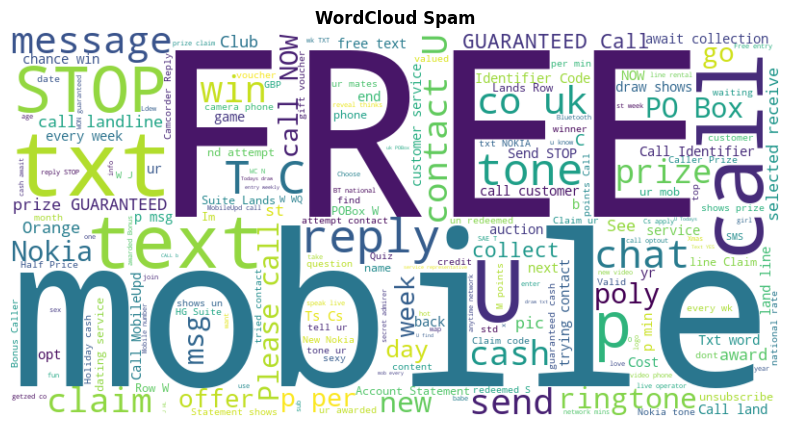

In [8]:
# Creazione della word cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Creiamo la wordcloud dalla stringa 'ham_words' che contiene tutte le parole dei messaggi Spam
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_words)


# Visualizzazione della word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Spam', fontweight= 'bold')
plt.show()

# 2. Text Preprocessing - Lemmatization

### Lemmatization

In [12]:
# Download nltk
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


nltk.download('all')


# Creiamo una lista contenente testi
text = list(df['Text'])


lemmatizer = WordNetLemmatizer()

# Loop per il preprocessing
corpus = []

for i in range(len(text)):

    # Rimuoviamo i caratteri speciali
    r = re.sub('[^a-zA-Z]', ' ', text[i])

    # Rendiamo tutto minuscolo
    r = r.lower()

    # Tokenizziamo le parole
    r = r.split()

    # Rimuoviamo le stopwords
    r = [word for word in r if word not in stopwords.words('english')]

    # Lemmatizzation
    r = [lemmatizer.lemmatize(word) for word in r]

    r = ' '.join(r)

    corpus.append(r)


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /Users/pio/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /Users/pio/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/pio/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/pio/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /Users/pio/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /Users/pio/nltk_data...
[nltk_data]    |   Pack

In [13]:
# Al fine di non modificare il dataset importato, e dover successivamente
# quindi ricaricarlo per il Text Preprocessing con lo Stemming,
# andiamo a creare un nuovo Dataframe che useremo nelle fasi relative alla Lemmatization
import pandas as pd


df_lem = pd.DataFrame()

df_lem['Text'] = corpus
df_lem['Class'] = df['Class']


# Vediamo la struttura
df_lem.head(5)

,Text,Class
0,go jurong point crazy available bugis n great ...,ham
1,ok lar joking wif u oni,ham
2,free entry wkly comp win fa cup final tkts st ...,spam
3,u dun say early hor u c already say,ham
4,nah dont think go usf life around though,ham


## 2.1 Addestramento dei classificatori - Feature Extraction: Bag of Words (CountVectorizer)

### Feature Extraction

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# Import del Classificatore Naive Bayes
from sklearn.naive_bayes import MultinomialNB

# Import del Classificatore Decision Tree
from sklearn import tree

# Import del Classificatore Support Vector Machine
from sklearn.svm import SVC

# Import del Classificatore Logistic Regression
from sklearn.linear_model import LogisticRegression

# Import del Classificatore DummyClassifier
from sklearn.dummy import DummyClassifier


from sklearn.metrics import accuracy_score

# 'df_lem' è il DataFrame Pandas contenente i dati 'Text' e 'Class'

# Dividiamo i dati in feature (X) e target (y)
X = df_lem['Text']
y = df_lem['Class']

# Estraiamo le feature dai dati testuali utilizzando una Bag of Words
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X)

# Vediamo le dimensioni della nostra matrice
# 
X.shape
# 5572 righe = messaggi
# 7121 colonne = parole

(5572, 7121)

### Train e Test Sets

In [15]:
# Dividiamo i dati in set di addestramento e set di test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Training Data:', X_train.shape)

print('Testing Data: ', X_test.shape)

Training Data: (4457, 7121)
Testing Data:  (1115, 7121)


### 2.1.1 - Addestramento modello: *MultinomialNB* e Valutazione

In [96]:
# Creiamo e addestriamo il classificatore (utilizzando ad esempio il classificatore Naive Bayes)
classifier = MultinomialNB()
classifier.fit(X_train.toarray(), y_train)

# Facciamo predizioni sul set di test
predictions = classifier.predict(X_test.toarray())

# Valutiamo le prestazioni del modello
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9739910313901345


In [97]:
# Valutiamo la preformance del classificatore sul test set
from sklearn import metrics


print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

         ham       0.99      0.98      0.98       965
        spam       0.88      0.94      0.91       150

    accuracy                           0.97      1115
   macro avg       0.93      0.96      0.95      1115
weighted avg       0.98      0.97      0.97      1115



### Confusion Matrix

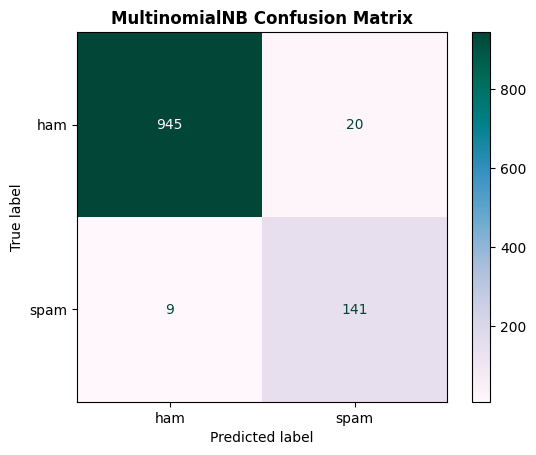

In [98]:
# Questo metodo di visualizzazione della Confusion Matrix, ovvero senza le percentuali,
# non è molto adatto per la rappresentazione dei risultati ottenuti, ad esempio vediamo come
# il colore dei veri negativi non è indicativo.

# In questo caso decidiamo di visualizzarla, come oggetto di confronto con la Confusion Matrix
# con le percentuali.

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Impostiamo il colore
cmap = plt.get_cmap('PuBuGn')

mx = metrics.confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = mx,
                              display_labels=classifier.classes_) 
disp.plot(cmap = cmap)
plt.title('MultinomialNB Confusion Matrix', fontweight = 'bold')
plt.show()

Class
ham     965
spam    150
Name: count, dtype: int64


Text(0.5, 1.0, 'Confusion Matrix in percentuale')

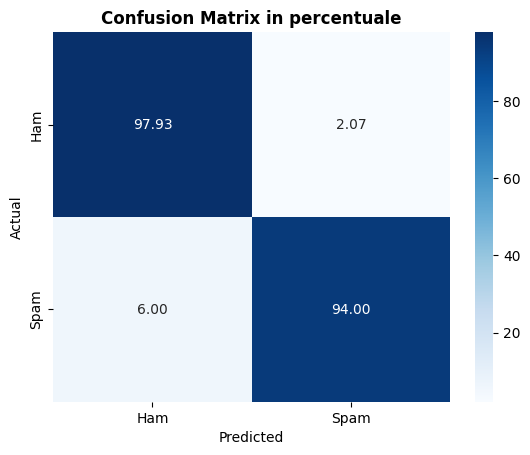

In [99]:
# Confusion Matrix con Valori percentuali
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns




# Vediamo il numero effettivo di Ham e il numero effettivo di Spam nel Test set
print(y_test.value_counts())


### Creazione Confusion Matrix

# Otteniamo i valori delle predizioni in un array (la matrice di confusione) 
mx = metrics.confusion_matrix(y_test, predictions)


# Creiamo un lista vuota che conterrà i valori percentuali
# Sarà una lista di liste e rappresenterà la nostra matrice
perc_cf_mx = []


# Accediamo agli elementi della matrice
for r in range(len(mx)):

    # l è una lista vuota che conterrà i valori di ogni RIGA
    l = []


    for c in range(len(mx)):
        
        # r == 0 -> Riga 0 = ham
        if r == 0:
            # Dividiamo il numero di ham previsti su quelli effettivi (965)
            m = (mx[r][c] / 965) * 100
            
        else:
            # Dividiamo il numero di spam previsti su quelli effettivi (150)
            m = (mx[r][c] / 150) * 100
            

        # Poniamo il rapporto percentuale nelle lista m
        l.append(round(m, 2))
    
    # Aggiungiamo la lista l alla lista perc_cf_mx (la nostra matrice)
    perc_cf_mx.append(l)

# Vediamo i valori percentuali ottenuti
#print(perc_cf_mx)


# Trasformiamo la matrice in un numpy array
perc_cf_mx = np.array(perc_cf_mx)



sns.heatmap(perc_cf_mx,
            annot = True, 
            fmt ='.2f', 
            cmap = 'Blues',
            xticklabels = ['Ham', 'Spam'],
            yticklabels = ['Ham', 'Spam'],
            )
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix in percentuale', fontweight = 'bold')


### 10-Fold Cross validation

In [100]:
from numpy import mean
from sklearn.model_selection import cross_val_score

# Selezioniamo il modello su cui fare la cross-validation
model = MultinomialNB()


# Definiamo i dati su cui efftuiamo l'addestramento 
# e il numero di porzioni 'cv' del dataset di partenza
cv_scores = cross_val_score(model, X, y, cv=10)
print('Accuracy dei classificatori: '+ str(cv_scores) + '\n')


# Media delle performances
print('Media delle performance: ' + str(mean(cv_scores)))

Accuracy dei classificatori: [0.96774194 0.97491039 0.97666068 0.98204668 0.96768402 0.97486535
 0.97486535 0.98204668 0.96947935 0.97486535]

Media delle performance: 0.9745165794740126


### 2.1.2 - Addestramento modello: *Support Vector Machine* e Valutazione

In [101]:
# Creiamo e addestriamo il classificatore SVM
classifier = SVC()
classifier.fit(X_train.toarray(), y_train)

# Facciamo predizioni sul set di test
predictions = classifier.predict(X_test.toarray())

# Valutiamo le prestazioni del modello
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9775784753363229


In [102]:
# Valutiamo la preformance del classificatore sul test set
from sklearn import metrics


print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       965
        spam       0.99      0.84      0.91       150

    accuracy                           0.98      1115
   macro avg       0.98      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115



### Confusion Matrix

Class
ham     965
spam    150
Name: count, dtype: int64


Text(0.5, 1.0, 'Confusion Matrix in percentuale')

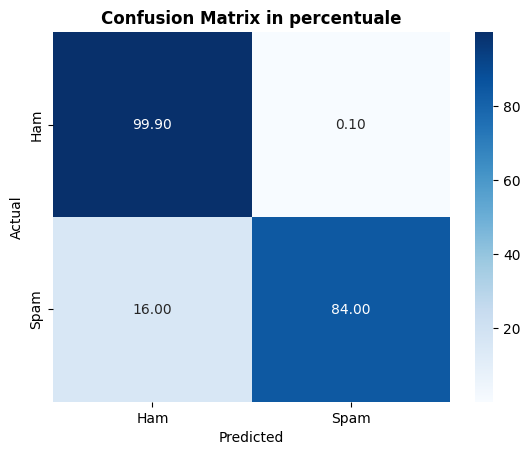

In [103]:
# Confusion Matrix con Valori percentuali
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns




# Vediamo il numero effettivo di Ham e il numero effettivo di Spam nel Test set
print(y_test.value_counts())


### Creazione Confusion Matrix

# Otteniamo i valori delle predizioni in un array (la matrice di confusione) 
mx = metrics.confusion_matrix(y_test, predictions)


# Creiamo un lista vuota che conterrà i valori percentuali
# Sarà una lista di liste e rappresenterà la nostra matrice
perc_cf_mx = []


# Accediamo agli elementi della matrice
for r in range(len(mx)):

    # l è una lista vuota che conterrà i valori di ogni RIGA
    l = []


    for c in range(len(mx)):
        
        # r == 0 -> Riga 0 = ham
        if r == 0:
            # Dividiamo il numero di ham previsti su quelli effettivi (965)
            m = (mx[r][c] / 965) * 100
            
        else:
            # Dividiamo il numero di spam previsti su quelli effettivi (150)
            m = (mx[r][c] / 150) * 100
            

        # Poniamo il rapporto percentuale nelle lista m
        l.append(round(m, 2))
    
    # Aggiungiamo la lista l alla lista perc_cf_mx (la nostra matrice)
    perc_cf_mx.append(l)

# Vediamo i valori percentuali ottenuti
#print(perc_cf_mx)


# Trasformiamo la matrice in un numpy array
perc_cf_mx = np.array(perc_cf_mx)



sns.heatmap(perc_cf_mx,
            annot = True, 
            fmt ='.2f', 
            cmap = 'Blues',
            xticklabels = ['Ham', 'Spam'],
            yticklabels = ['Ham', 'Spam'],
            )
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix in percentuale', fontweight = 'bold')


### 10-Fold Cross Validation

In [104]:
from numpy import mean
from sklearn.model_selection import cross_val_score

# Selezioniamo il modello su cui fare la cross-validation
model = SVC()


# Definiamo i dati su cui efftuiamo l'addestramento 
# e il numero di porzioni 'cv' del dataset di partenza
cv_scores = cross_val_score(model, X, y, cv=10)
print('Accuracy dei classificatori: '+ str(cv_scores) + '\n')


# Media delle performances
print('Media delle performance: ' + str(mean(cv_scores)))

Accuracy dei classificatori: [0.98924731 0.97132616 0.98025135 0.98204668 0.97845601 0.97845601
 0.97486535 0.97666068 0.97307002 0.98384201]

Media delle performance: 0.9788221591603765


### 2.1.3 - Addestramento modello: *Logistic Regression* e Valutazione

In [105]:
# Creiamo e addestriamo il classificatore Logistic Regression
classifier = LogisticRegression()
classifier.fit(X_train.toarray(), y_train)

# Facciamo predizioni sul set di test
predictions = classifier.predict(X_test.toarray())

# Valutiamo le prestazioni del modello
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9775784753363229


In [106]:
# Valutiamo la preformance del classificatore sul test set
from sklearn import metrics


print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

         ham       0.97      1.00      0.99       965
        spam       1.00      0.83      0.91       150

    accuracy                           0.98      1115
   macro avg       0.99      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115



### Confusion Matrix

Class
ham     965
spam    150
Name: count, dtype: int64


Text(0.5, 1.0, 'Confusion Matrix in percentuale')

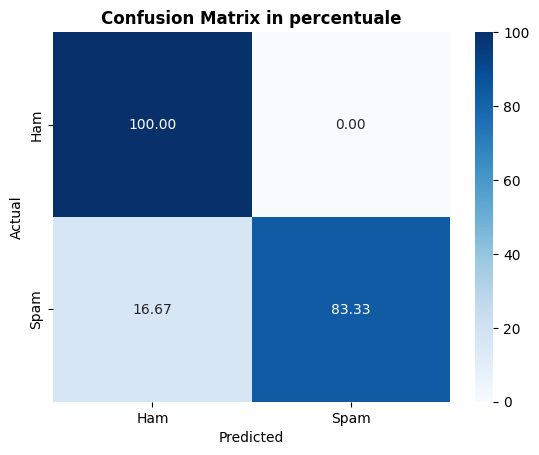

In [107]:
# Confusion Matrix con Valori percentuali
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns




# Vediamo il numero effettivo di Ham e il numero effettivo di Spam nel Test set
print(y_test.value_counts())


### Creazione Confusion Matrix

# Otteniamo i valori delle predizioni in un array (la matrice di confusione) 
mx = metrics.confusion_matrix(y_test, predictions)


# Creiamo un lista vuota che conterrà i valori percentuali
# Sarà una lista di liste e rappresenterà la nostra matrice
perc_cf_mx = []


# Accediamo agli elementi della matrice
for r in range(len(mx)):

    # l è una lista vuota che conterrà i valori di ogni RIGA
    l = []


    for c in range(len(mx)):
        
        # r == 0 -> Riga 0 = ham
        if r == 0:
            # Dividiamo il numero di ham previsti su quelli effettivi (965)
            m = (mx[r][c] / 965) * 100
            
        else:
            # Dividiamo il numero di spam previsti su quelli effettivi (150)
            m = (mx[r][c] / 150) * 100
            

        # Poniamo il rapporto percentuale nelle lista m
        l.append(round(m, 2))
    
    # Aggiungiamo la lista l alla lista perc_cf_mx (la nostra matrice)
    perc_cf_mx.append(l)

# Vediamo i valori percentuali ottenuti
#print(perc_cf_mx)


# Trasformiamo la matrice in un numpy array
perc_cf_mx = np.array(perc_cf_mx)



sns.heatmap(perc_cf_mx,
            annot = True, 
            fmt ='.2f', 
            cmap = 'Blues',
            xticklabels = ['Ham', 'Spam'],
            yticklabels = ['Ham', 'Spam'],
            )
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix in percentuale', fontweight = 'bold')


### 10-Fold Cross Validation

In [108]:
from numpy import mean
from sklearn.model_selection import cross_val_score

# Selezioniamo il modello su cui fare la cross-validation
model = LogisticRegression()


# Definiamo i dati su cui efftuiamo l'addestramento 
# e il numero di porzioni 'cv' del dataset di partenza
cv_scores = cross_val_score(model, X, y, cv=10)
print('Accuracy dei classificatori: '+ str(cv_scores) + '\n')


# Media delle performances
print('Media delle performance: ' + str(mean(cv_scores)))

Accuracy dei classificatori: [0.98566308 0.97491039 0.98204668 0.98563734 0.98204668 0.98204668
 0.98204668 0.98025135 0.98025135 0.98743268]

Media delle performance: 0.9822332902196227


### 2.1.4 - Addestramento modello: *Decision Tree* e Valutazione

In [109]:
# Creiamo e addestriamo il classificatore Decision Tree
classifier = tree.DecisionTreeClassifier()
classifier.fit(X_train.toarray(), y_train)

# Facciamo predizioni sul set di test
predictions = classifier.predict(X_test.toarray())

# Valutiamo le prestazioni del modello
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9695067264573991


In [110]:
# Valutiamo la preformance del classificatore sul test set
from sklearn import metrics


print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

         ham       0.97      0.99      0.98       965
        spam       0.95      0.82      0.88       150

    accuracy                           0.97      1115
   macro avg       0.96      0.91      0.93      1115
weighted avg       0.97      0.97      0.97      1115



### Confusion Matrix

Class
ham     965
spam    150
Name: count, dtype: int64


Text(0.5, 1.0, 'Confusion Matrix in percentuale')

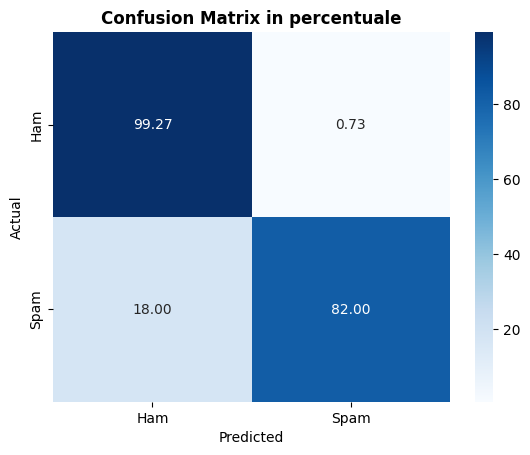

In [111]:
# Confusion Matrix con Valori percentuali
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns




# Vediamo il numero effettivo di Ham e il numero effettivo di Spam nel Test set
print(y_test.value_counts())


### Creazione Confusion Matrix

# Otteniamo i valori delle predizioni in un array (la matrice di confusione) 
mx = metrics.confusion_matrix(y_test, predictions)


# Creiamo un lista vuota che conterrà i valori percentuali
# Sarà una lista di liste e rappresenterà la nostra matrice
perc_cf_mx = []


# Accediamo agli elementi della matrice
for r in range(len(mx)):

    # l è una lista vuota che conterrà i valori di ogni RIGA
    l = []


    for c in range(len(mx)):
        
        # r == 0 -> Riga 0 = ham
        if r == 0:
            # Dividiamo il numero di ham previsti su quelli effettivi (965)
            m = (mx[r][c] / 965) * 100
            
        else:
            # Dividiamo il numero di spam previsti su quelli effettivi (150)
            m = (mx[r][c] / 150) * 100
            

        # Poniamo il rapporto percentuale nelle lista m
        l.append(round(m, 2))
    
    # Aggiungiamo la lista l alla lista perc_cf_mx (la nostra matrice)
    perc_cf_mx.append(l)

# Vediamo i valori percentuali ottenuti
#print(perc_cf_mx)


# Trasformiamo la matrice in un numpy array
perc_cf_mx = np.array(perc_cf_mx)



sns.heatmap(perc_cf_mx,
            annot = True, 
            fmt ='.2f', 
            cmap = 'Blues',
            xticklabels = ['Ham', 'Spam'],
            yticklabels = ['Ham', 'Spam'],
            )
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix in percentuale', fontweight = 'bold')


### 10-Fold Cross Validation

In [112]:
from numpy import mean
from sklearn.model_selection import cross_val_score

# Selezioniamo il modello su cui fare la cross-validation
model = tree.DecisionTreeClassifier()


# Definiamo i dati su cui efftuiamo l'addestramento 
# e il numero di porzioni 'cv' del dataset di partenza
cv_scores = cross_val_score(model, X, y, cv=10)
print('Accuracy dei classificatori: '+ str(cv_scores) + '\n')


# Media delle performances
print('Media delle performance: ' + str(mean(cv_scores)))

Accuracy dei classificatori: [0.98924731 0.96953405 0.97486535 0.97666068 0.97307002 0.96588869
 0.96229803 0.98025135 0.97127469 0.98384201]

Media delle performance: 0.974693216990663


### 2.1.5 - Addestramento modello: *Dummy Classifier* e Valutazione

In [113]:
# Creiamo e addestriamo il classificatore DummyClassifier
classifier = DummyClassifier()
classifier.fit(X_train.toarray(), y_train)

# Facciamo predizioni sul set di test
predictions = classifier.predict(X_test.toarray())

# Valutiamo le prestazioni del modello
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8654708520179372


In [114]:
# Valutiamo la preformance del classificatore sul test set
from sklearn import metrics


print(metrics.classification_report(y_test, predictions, zero_division='warn'))

              precision    recall  f1-score   support

         ham       0.87      1.00      0.93       965
        spam       0.00      0.00      0.00       150

    accuracy                           0.87      1115
   macro avg       0.43      0.50      0.46      1115
weighted avg       0.75      0.87      0.80      1115



/Users/pio/anaconda3/envs/spamdetection/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/pio/anaconda3/envs/spamdetection/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/pio/anaconda3/envs/spamdetection/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

### Confusion Matrix

Class
ham     965
spam    150
Name: count, dtype: int64


Text(0.5, 1.0, 'Confusion Matrix in percentuale')

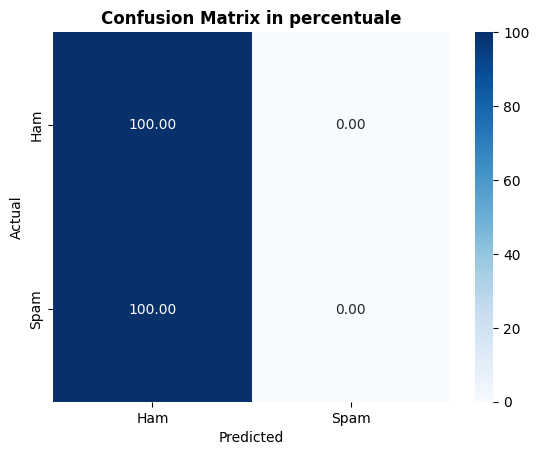

In [115]:
# Confusion Matrix con Valori percentuali
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns




# Vediamo il numero effettivo di Ham e il numero effettivo di Spam nel Test set
print(y_test.value_counts())


### Creazione Confusion Matrix

# Otteniamo i valori delle predizioni in un array (la matrice di confusione) 
mx = metrics.confusion_matrix(y_test, predictions)


# Creiamo un lista vuota che conterrà i valori percentuali
# Sarà una lista di liste e rappresenterà la nostra matrice
perc_cf_mx = []


# Accediamo agli elementi della matrice
for r in range(len(mx)):

    # l è una lista vuota che conterrà i valori di ogni RIGA
    l = []


    for c in range(len(mx)):
        
        # r == 0 -> Riga 0 = ham
        if r == 0:
            # Dividiamo il numero di ham previsti su quelli effettivi (965)
            m = (mx[r][c] / 965) * 100
            
        else:
            # Dividiamo il numero di spam previsti su quelli effettivi (150)
            m = (mx[r][c] / 150) * 100
            

        # Poniamo il rapporto percentuale nelle lista m
        l.append(round(m, 2))
    
    # Aggiungiamo la lista l alla lista perc_cf_mx (la nostra matrice)
    perc_cf_mx.append(l)

# Vediamo i valori percentuali ottenuti
#print(perc_cf_mx)


# Trasformiamo la matrice in un numpy array
perc_cf_mx = np.array(perc_cf_mx)



sns.heatmap(perc_cf_mx,
            annot = True, 
            fmt ='.2f', 
            cmap = 'Blues',
            xticklabels = ['Ham', 'Spam'],
            yticklabels = ['Ham', 'Spam'],
            )
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix in percentuale', fontweight = 'bold')


### 10-Fold Cross Validation

In [116]:
from numpy import mean
from sklearn.model_selection import cross_val_score

# Selezioniamo il modello su cui fare la cross-validation
model = DummyClassifier()


# Definiamo i dati su cui efftuiamo l'addestramento 
# e il numero di porzioni 'cv' del dataset di partenza
cv_scores = cross_val_score(model, X, y, cv=10)
print('Accuracy dei classificatori: '+ str(cv_scores) + '\n')


# Media delle performances
print('Media delle performance: ' + str(mean(cv_scores)))

Accuracy dei classificatori: [0.8655914  0.8655914  0.86714542 0.86714542 0.86714542 0.86535009
 0.86535009 0.86535009 0.86535009 0.86535009]

Media delle performance: 0.8659369510241115


## 2.2 Addestramento dei classificatori - Feature Extraction: TF-IDF (TfidfVectorizer)

### Feature Extraction

In [117]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Import del Classificatore Naive Bayes
from sklearn.naive_bayes import MultinomialNB

# Import del Classificatore Decision Tree
from sklearn import tree

# Import del Classificatore Support Vector Machine
from sklearn.svm import SVC

# Import del Classificatore Logistic Regression
from sklearn.linear_model import LogisticRegression

from sklearn.dummy import DummyClassifier

from sklearn.metrics import accuracy_score

# 'df_lem' è il DataFrame Pandas contenente i dati 'Text' e 'Class'

# Dividiamo i dati in feature (X) e target (y)
X = df_lem['Text']
y = df_lem['Class']

# Estraiamo le feature dai dati testuali utilizzando una Bag of Words
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X)

X.shape

(5572, 7121)

### Train e Test Sets

In [118]:
# Dividiamo i dati in set di addestramento e set di test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Training Data:', X_train.shape)

print('Testing Data: ', X_test.shape)

Training Data: (4457, 7121)
Testing Data:  (1115, 7121)


### 2.2.1 - Addestramento modello: *MultinomialNB* e Valutazione

In [119]:
# Creiamo e addestriamo il classificatore (utilizzando ad esempio il classificatore Naive Bayes)
classifier = MultinomialNB()
classifier.fit(X_train.toarray(), y_train)

# Facciamo predizioni sul set di test
predictions = classifier.predict(X_test.toarray())

# Valutiamo le prestazioni del modello
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9623318385650225


In [120]:
# Valutiamo la preformance del classificatore sul test set
from sklearn import metrics


print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       965
        spam       0.99      0.73      0.84       150

    accuracy                           0.96      1115
   macro avg       0.98      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115



### Confusion Matrix

Class
ham     965
spam    150
Name: count, dtype: int64


Text(0.5, 1.0, 'Confusion Matrix in percentuale')

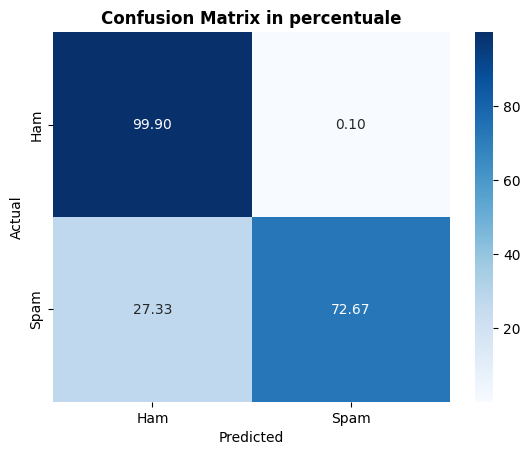

In [121]:
# Confusion Matrix con Valori percentuali
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns




# Vediamo il numero effettivo di Ham e il numero effettivo di Spam nel Test set
print(y_test.value_counts())


### Creazione Confusion Matrix

# Otteniamo i valori delle predizioni in un array (la matrice di confusione) 
mx = metrics.confusion_matrix(y_test, predictions)


# Creiamo un lista vuota che conterrà i valori percentuali
# Sarà una lista di liste e rappresenterà la nostra matrice
perc_cf_mx = []


# Accediamo agli elementi della matrice
for r in range(len(mx)):

    # l è una lista vuota che conterrà i valori di ogni RIGA
    l = []


    for c in range(len(mx)):
        
        # r == 0 -> Riga 0 = ham
        if r == 0:
            # Dividiamo il numero di ham previsti su quelli effettivi (965)
            m = (mx[r][c] / 965) * 100
            
        else:
            # Dividiamo il numero di spam previsti su quelli effettivi (150)
            m = (mx[r][c] / 150) * 100
            

        # Poniamo il rapporto percentuale nelle lista m
        l.append(round(m, 2))
    
    # Aggiungiamo la lista l alla lista perc_cf_mx (la nostra matrice)
    perc_cf_mx.append(l)

# Vediamo i valori percentuali ottenuti
#print(perc_cf_mx)


# Trasformiamo la matrice in un numpy array
perc_cf_mx = np.array(perc_cf_mx)



sns.heatmap(perc_cf_mx,
            annot = True, 
            fmt ='.2f', 
            cmap = 'Blues',
            xticklabels = ['Ham', 'Spam'],
            yticklabels = ['Ham', 'Spam'],
            )
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix in percentuale', fontweight = 'bold')


### 10-Fold Cross Validation

In [122]:
from numpy import mean
from sklearn.model_selection import cross_val_score

# Selezioniamo il modello su cui fare la cross-validation
model = MultinomialNB()


# Definiamo i dati su cui efftuiamo l'addestramento 
# e il numero di porzioni 'cv' del dataset di partenza
cv_scores = cross_val_score(model, X, y, cv=10)
print('Accuracy dei classificatori: '+ str(cv_scores) + '\n')


# Media delle performances
print('Media delle performance: ' + str(mean(cv_scores)))

Accuracy dei classificatori: [0.97849462 0.97491039 0.96409336 0.97486535 0.95870736 0.96947935
 0.96409336 0.96768402 0.96768402 0.98025135]

Media delle performance: 0.9700263186682369


### 2.2.2 - Addestramento modello: *Support Vector Machine* e Valutazione

In [123]:
# Creiamo e addestriamo il classificatore SVM
classifier = SVC()
classifier.fit(X_train.toarray(), y_train)

# Facciamo predizioni sul set di test
predictions = classifier.predict(X_test.toarray())

# Valutiamo le prestazioni del modello
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.97847533632287


In [124]:
# Valutiamo la preformance del classificatore sul test set
from sklearn import metrics


print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       965
        spam       1.00      0.84      0.91       150

    accuracy                           0.98      1115
   macro avg       0.99      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115



### Confusion Matrix

Class
ham     965
spam    150
Name: count, dtype: int64


Text(0.5, 1.0, 'Confusion Matrix in percentuale')

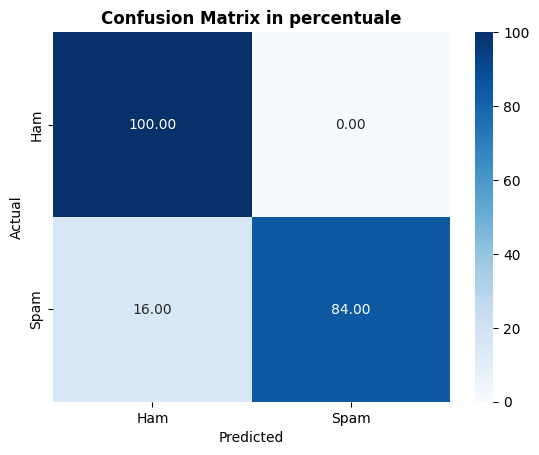

In [125]:
# Confusion Matrix con Valori percentuali
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns




# Vediamo il numero effettivo di Ham e il numero effettivo di Spam nel Test set
print(y_test.value_counts())


### Creazione Confusion Matrix

# Otteniamo i valori delle predizioni in un array (la matrice di confusione) 
mx = metrics.confusion_matrix(y_test, predictions)


# Creiamo un lista vuota che conterrà i valori percentuali
# Sarà una lista di liste e rappresenterà la nostra matrice
perc_cf_mx = []


# Accediamo agli elementi della matrice
for r in range(len(mx)):

    # l è una lista vuota che conterrà i valori di ogni RIGA
    l = []


    for c in range(len(mx)):
        
        # r == 0 -> Riga 0 = ham
        if r == 0:
            # Dividiamo il numero di ham previsti su quelli effettivi (965)
            m = (mx[r][c] / 965) * 100
            
        else:
            # Dividiamo il numero di spam previsti su quelli effettivi (150)
            m = (mx[r][c] / 150) * 100
            

        # Poniamo il rapporto percentuale nelle lista m
        l.append(round(m, 2))
    
    # Aggiungiamo la lista l alla lista perc_cf_mx (la nostra matrice)
    perc_cf_mx.append(l)

# Vediamo i valori percentuali ottenuti
#print(perc_cf_mx)


# Trasformiamo la matrice in un numpy array
perc_cf_mx = np.array(perc_cf_mx)



sns.heatmap(perc_cf_mx,
            annot = True, 
            fmt ='.2f', 
            cmap = 'Blues',
            xticklabels = ['Ham', 'Spam'],
            yticklabels = ['Ham', 'Spam'],
            )
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix in percentuale', fontweight = 'bold')


### 10-Fold Cross Validation

In [126]:
from numpy import mean
from sklearn.model_selection import cross_val_score

# Selezioniamo il modello su cui fare la cross-validation
model = SVC()


# Definiamo i dati su cui efftuiamo l'addestramento 
# e il numero di porzioni 'cv' del dataset di partenza
cv_scores = cross_val_score(model, X, y, cv=10)
print('Accuracy dei classificatori: '+ str(cv_scores) + '\n')


# Media delle performances
print('Media delle performance: ' + str(mean(cv_scores)))

Accuracy dei classificatori: [0.9874552  0.96774194 0.97845601 0.98204668 0.97486535 0.97845601
 0.97307002 0.97486535 0.97486535 0.98204668]

Media delle performance: 0.9773868586835519


### 2.2.3 - Addestramento modello: *Logistic Regression* e Valutazione

In [127]:
# Creiamo e addestriamo il classificatore Logistic Regression
classifier = LogisticRegression()
classifier.fit(X_train.toarray(), y_train)

# Facciamo predizioni sul set di test
predictions = classifier.predict(X_test.toarray())

# Valutiamo le prestazioni del modello
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9533632286995516


In [128]:
# Valutiamo la preformance del classificatore sul test set
from sklearn import metrics


print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

         ham       0.95      1.00      0.97       965
        spam       0.96      0.68      0.80       150

    accuracy                           0.95      1115
   macro avg       0.96      0.84      0.89      1115
weighted avg       0.95      0.95      0.95      1115



### Confusion Matrix

Class
ham     965
spam    150
Name: count, dtype: int64


Text(0.5, 1.0, 'Confusion Matrix in percentuale')

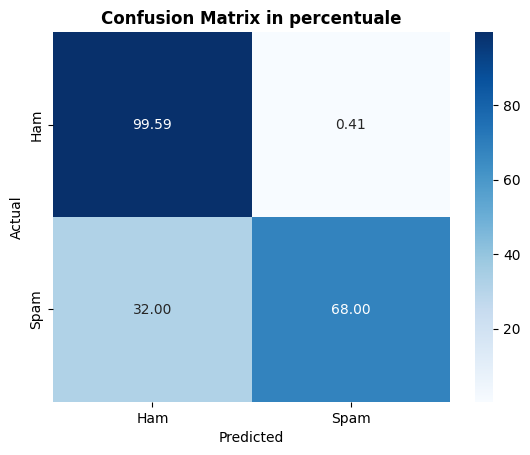

In [129]:
# Confusion Matrix con Valori percentuali
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns




# Vediamo il numero effettivo di Ham e il numero effettivo di Spam nel Test set
print(y_test.value_counts())


### Creazione Confusion Matrix

# Otteniamo i valori delle predizioni in un array (la matrice di confusione) 
mx = metrics.confusion_matrix(y_test, predictions)


# Creiamo un lista vuota che conterrà i valori percentuali
# Sarà una lista di liste e rappresenterà la nostra matrice
perc_cf_mx = []


# Accediamo agli elementi della matrice
for r in range(len(mx)):

    # l è una lista vuota che conterrà i valori di ogni RIGA
    l = []


    for c in range(len(mx)):
        
        # r == 0 -> Riga 0 = ham
        if r == 0:
            # Dividiamo il numero di ham previsti su quelli effettivi (965)
            m = (mx[r][c] / 965) * 100
            
        else:
            # Dividiamo il numero di spam previsti su quelli effettivi (150)
            m = (mx[r][c] / 150) * 100
            

        # Poniamo il rapporto percentuale nelle lista m
        l.append(round(m, 2))
    
    # Aggiungiamo la lista l alla lista perc_cf_mx (la nostra matrice)
    perc_cf_mx.append(l)

# Vediamo i valori percentuali ottenuti
#print(perc_cf_mx)


# Trasformiamo la matrice in un numpy array
perc_cf_mx = np.array(perc_cf_mx)



sns.heatmap(perc_cf_mx,
            annot = True, 
            fmt ='.2f', 
            cmap = 'Blues',
            xticklabels = ['Ham', 'Spam'],
            yticklabels = ['Ham', 'Spam'],
            )
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix in percentuale', fontweight = 'bold')


### 10-Fold Cross Validation

In [130]:
from numpy import mean
from sklearn.model_selection import cross_val_score

# Selezioniamo il modello su cui fare la cross-validation
model = LogisticRegression()


# Definiamo i dati su cui efftuiamo l'addestramento 
# e il numero di porzioni 'cv' del dataset di partenza
cv_scores = cross_val_score(model, X, y, cv=10)
print('Accuracy dei classificatori: '+ str(cv_scores) + '\n')


# Media delle performances
print('Media delle performance: ' + str(mean(cv_scores)))

Accuracy dei classificatori: [0.96236559 0.96236559 0.95691203 0.97127469 0.96588869 0.95870736
 0.95691203 0.96768402 0.96050269 0.97127469]

Media delle performance: 0.963388737669157


### 2.2.4 - Addestramento modello: *Decision Tree* e Valutazione

In [131]:
# Creiamo e addestriamo il classificatore Decision Tree
classifier = tree.DecisionTreeClassifier()
classifier.fit(X_train.toarray(), y_train)

# Facciamo predizioni sul set di test
predictions = classifier.predict(X_test.toarray())

# Valutiamo le prestazioni del modello
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9695067264573991


In [132]:
# Valutiamo la preformance del classificatore sul test set
from sklearn import metrics


print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

         ham       0.98      0.99      0.98       965
        spam       0.90      0.87      0.88       150

    accuracy                           0.97      1115
   macro avg       0.94      0.93      0.93      1115
weighted avg       0.97      0.97      0.97      1115



### Confusion Matrix

Class
ham     965
spam    150
Name: count, dtype: int64


Text(0.5, 1.0, 'Confusion Matrix in percentuale')

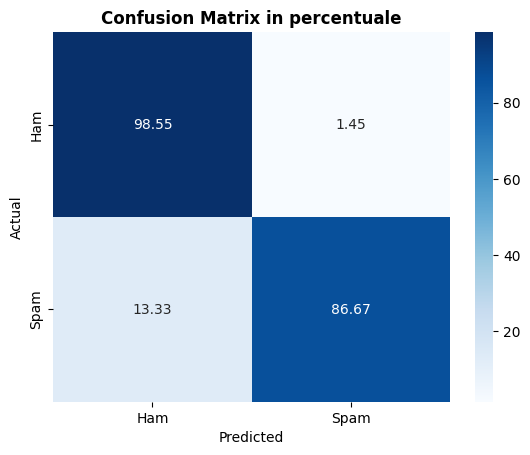

In [133]:
# Confusion Matrix con Valori percentuali
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns




# Vediamo il numero effettivo di Ham e il numero effettivo di Spam nel Test set
print(y_test.value_counts())


### Creazione Confusion Matrix

# Otteniamo i valori delle predizioni in un array (la matrice di confusione) 
mx = metrics.confusion_matrix(y_test, predictions)


# Creiamo un lista vuota che conterrà i valori percentuali
# Sarà una lista di liste e rappresenterà la nostra matrice
perc_cf_mx = []


# Accediamo agli elementi della matrice
for r in range(len(mx)):

    # l è una lista vuota che conterrà i valori di ogni RIGA
    l = []


    for c in range(len(mx)):
        
        # r == 0 -> Riga 0 = ham
        if r == 0:
            # Dividiamo il numero di ham previsti su quelli effettivi (965)
            m = (mx[r][c] / 965) * 100
            
        else:
            # Dividiamo il numero di spam previsti su quelli effettivi (150)
            m = (mx[r][c] / 150) * 100
            

        # Poniamo il rapporto percentuale nelle lista m
        l.append(round(m, 2))
    
    # Aggiungiamo la lista l alla lista perc_cf_mx (la nostra matrice)
    perc_cf_mx.append(l)

# Vediamo i valori percentuali ottenuti
#print(perc_cf_mx)


# Trasformiamo la matrice in un numpy array
perc_cf_mx = np.array(perc_cf_mx)



sns.heatmap(perc_cf_mx,
            annot = True, 
            fmt ='.2f', 
            cmap = 'Blues',
            xticklabels = ['Ham', 'Spam'],
            yticklabels = ['Ham', 'Spam'],
            )
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix in percentuale', fontweight = 'bold')


### 10-Fold Cross Validation

In [134]:
from numpy import mean
from sklearn.model_selection import cross_val_score

# Selezioniamo il modello su cui fare la cross-validation
model = tree.DecisionTreeClassifier()


# Definiamo i dati su cui efftuiamo l'addestramento 
# e il numero di porzioni 'cv' del dataset di partenza
cv_scores = cross_val_score(model, X, y, cv=10)
print('Accuracy dei classificatori: '+ str(cv_scores) + '\n')


# Media delle performances
print('Media delle performance: ' + str(mean(cv_scores)))

Accuracy dei classificatori: [0.97132616 0.96774194 0.96947935 0.96768402 0.97307002 0.96588869
 0.96229803 0.95870736 0.97127469 0.97486535]

Media delle performance: 0.9682335604846752


### 2.2.5 - Addestramento modello: *Dummy Classifier* e Valutazione

In [135]:
# Creiamo e addestriamo il classificatore DummyClassifier
classifier = DummyClassifier()
classifier.fit(X_train.toarray(), y_train)

# Facciamo predizioni sul set di test
predictions = classifier.predict(X_test.toarray())

# Valutiamo le prestazioni del modello
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8654708520179372


In [136]:
# Valutiamo la preformance del classificatore sul test set
from sklearn import metrics


print(metrics.classification_report(y_test, predictions, zero_division='warn'))

              precision    recall  f1-score   support

         ham       0.87      1.00      0.93       965
        spam       0.00      0.00      0.00       150

    accuracy                           0.87      1115
   macro avg       0.43      0.50      0.46      1115
weighted avg       0.75      0.87      0.80      1115



/Users/pio/anaconda3/envs/spamdetection/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/pio/anaconda3/envs/spamdetection/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/pio/anaconda3/envs/spamdetection/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

### Confusion Matrix

Class
ham     965
spam    150
Name: count, dtype: int64


Text(0.5, 1.0, 'Confusion Matrix in percentuale')

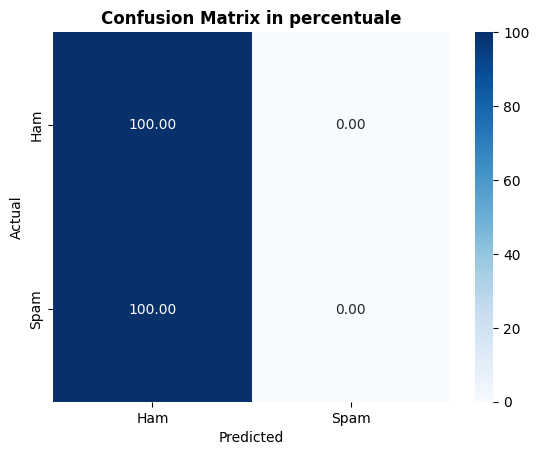

In [137]:
# Confusion Matrix con Valori percentuali
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns




# Vediamo il numero effettivo di Ham e il numero effettivo di Spam nel Test set
print(y_test.value_counts())


### Creazione Confusion Matrix

# Otteniamo i valori delle predizioni in un array (la matrice di confusione) 
mx = metrics.confusion_matrix(y_test, predictions)


# Creiamo un lista vuota che conterrà i valori percentuali
# Sarà una lista di liste e rappresenterà la nostra matrice
perc_cf_mx = []


# Accediamo agli elementi della matrice
for r in range(len(mx)):

    # l è una lista vuota che conterrà i valori di ogni RIGA
    l = []


    for c in range(len(mx)):
        
        # r == 0 -> Riga 0 = ham
        if r == 0:
            # Dividiamo il numero di ham previsti su quelli effettivi (965)
            m = (mx[r][c] / 965) * 100
            
        else:
            # Dividiamo il numero di spam previsti su quelli effettivi (150)
            m = (mx[r][c] / 150) * 100
            

        # Poniamo il rapporto percentuale nelle lista m
        l.append(round(m, 2))
    
    # Aggiungiamo la lista l alla lista perc_cf_mx (la nostra matrice)
    perc_cf_mx.append(l)

# Vediamo i valori percentuali ottenuti
#print(perc_cf_mx)


# Trasformiamo la matrice in un numpy array
perc_cf_mx = np.array(perc_cf_mx)



sns.heatmap(perc_cf_mx,
            annot = True, 
            fmt ='.2f', 
            cmap = 'Blues',
            xticklabels = ['Ham', 'Spam'],
            yticklabels = ['Ham', 'Spam'],
            )
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix in percentuale', fontweight = 'bold')


### 10-Fold Cross Validation

In [138]:
from numpy import mean
from sklearn.model_selection import cross_val_score

# Selezioniamo il modello su cui fare la cross-validation
model = DummyClassifier()


# Definiamo i dati su cui efftuiamo l'addestramento 
# e il numero di porzioni 'cv' del dataset di partenza
cv_scores = cross_val_score(model, X, y, cv=10)
print('Accuracy dei classificatori: '+ str(cv_scores) + '\n')


# Media delle performances
print('Media delle performance: ' + str(mean(cv_scores)))

Accuracy dei classificatori: [0.8655914  0.8655914  0.86714542 0.86714542 0.86714542 0.86535009
 0.86535009 0.86535009 0.86535009 0.86535009]

Media delle performance: 0.8659369510241115


# 3. Text Preprocessing - Stemminng

### Stemming

In [139]:
# Download nltk
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

nltk.download("punkt")

nltk.download('stopwords')

nltk.download('wordnet')

# Initialize Python porter stemmer
ps = PorterStemmer()


texts = list(df['Text'])



sentences = []
for tx in texts:

  t = re.sub('[^A-Za-z]', ' ', tx)

  t = t.lower()

  words = word_tokenize(t)

  word = [ps.stem(i) for i in words if i not in stopwords.words('english')]

  t = ' '.join(word)

  sentences.append(t)


[nltk_data] Downloading package punkt to /Users/pio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/pio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/pio/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [140]:
# Per non modificare il dataframe 'df' andiamo a creare il dataframe 'df_stem' relativo
# al solo Text preprocessing con lo stemming
import pandas as pd


df_stem = pd.DataFrame()

df_stem['Text'] = sentences
df_stem['Class'] = df['Class']


# Vediamo la struttura
df_stem.head(5)

,Text,Class
0,go jurong point crazi avail bugi n great world...,ham
1,ok lar joke wif u oni,ham
2,free entri wkli comp win fa cup final tkt st m...,spam
3,u dun say earli hor u c alreadi say,ham
4,nah dont think goe usf live around though,ham


## 3.1 Addestramento dei classificatori - Feature Extraction: Bag of Words (CountVectorizer)

### Feature Extraction

In [141]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# Import del Classificatore Naive Bayes
from sklearn.naive_bayes import MultinomialNB

# Import del Classificatore Decision Tree
from sklearn import tree

# Import del Classificatore Support Vector Machine
from sklearn.svm import SVC

# Import del Classificatore Logistic Regression
from sklearn.linear_model import LogisticRegression

from sklearn.dummy import DummyClassifier

from sklearn.metrics import accuracy_score

# 'df_stem' è il DataFrame Pandas contenente i dati 'Text' e 'Class'

# Dividiamo i dati in feature (X) e target (y)
X = df_stem['Text']
y = df_stem['Class']

# Estraiamo le feature dai dati testuali utilizzando una Bag of Words
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X)

X.shape

(5572, 6303)

### Train e Test Sets

In [142]:
# Dividiamo i dati in set di addestramento e set di test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Training Data:', X_train.shape)

print('Testing Data: ', X_test.shape)

Training Data: (4457, 6303)
Testing Data:  (1115, 6303)


### 3.1.1 - Addestramento modello: *MultinomialNB* e Valutazione

In [143]:
# Creiamo e addestriamo il classificatore (utilizzando ad esempio il classificatore Naive Bayes)
classifier = MultinomialNB()
classifier.fit(X_train.toarray(), y_train)

# Facciamo predizioni sul set di test
predictions = classifier.predict(X_test.toarray())

# Valutiamo le prestazioni del modello
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9757847533632287


In [144]:
# Valutiamo la preformance del classificatore sul test set
from sklearn import metrics


print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

         ham       0.99      0.98      0.99       965
        spam       0.88      0.95      0.91       150

    accuracy                           0.98      1115
   macro avg       0.94      0.96      0.95      1115
weighted avg       0.98      0.98      0.98      1115



### Confusion Matrix

Class
ham     965
spam    150
Name: count, dtype: int64


Text(0.5, 1.0, 'Confusion Matrix in percentuale')

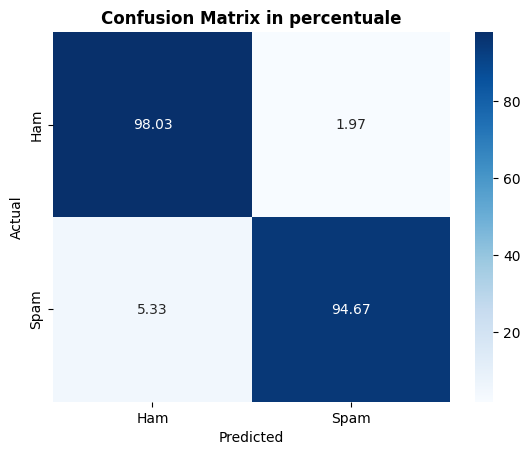

In [145]:
# Confusion Matrix con Valori percentuali
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns




# Vediamo il numero effettivo di Ham e il numero effettivo di Spam nel Test set
print(y_test.value_counts())


### Creazione Confusion Matrix

# Otteniamo i valori delle predizioni in un array (la matrice di confusione) 
mx = metrics.confusion_matrix(y_test, predictions)


# Creiamo un lista vuota che conterrà i valori percentuali
# Sarà una lista di liste e rappresenterà la nostra matrice
perc_cf_mx = []


# Accediamo agli elementi della matrice
for r in range(len(mx)):

    # l è una lista vuota che conterrà i valori di ogni RIGA
    l = []


    for c in range(len(mx)):
        
        # r == 0 -> Riga 0 = ham
        if r == 0:
            # Dividiamo il numero di ham previsti su quelli effettivi (965)
            m = (mx[r][c] / 965) * 100
            
        else:
            # Dividiamo il numero di spam previsti su quelli effettivi (150)
            m = (mx[r][c] / 150) * 100
            

        # Poniamo il rapporto percentuale nelle lista m
        l.append(round(m, 2))
    
    # Aggiungiamo la lista l alla lista perc_cf_mx (la nostra matrice)
    perc_cf_mx.append(l)

# Vediamo i valori percentuali ottenuti
#print(perc_cf_mx)


# Trasformiamo la matrice in un numpy array
perc_cf_mx = np.array(perc_cf_mx)



sns.heatmap(perc_cf_mx,
            annot = True, 
            fmt ='.2f', 
            cmap = 'Blues',
            xticklabels = ['Ham', 'Spam'],
            yticklabels = ['Ham', 'Spam'],
            )
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix in percentuale', fontweight = 'bold')


### 10-Fold Cross Validation

In [146]:
from numpy import mean
from sklearn.model_selection import cross_val_score

# Selezioniamo il modello su cui fare la cross-validation
model = MultinomialNB()


# Definiamo i dati su cui efftuiamo l'addestramento 
# e il numero di porzioni 'cv' del dataset di partenza
cv_scores = cross_val_score(model, X, y, cv=10)
print('Accuracy dei classificatori: '+ str(cv_scores) + '\n')


# Media delle performances
print('Media delle performance: ' + str(mean(cv_scores)))

Accuracy dei classificatori: [0.97491039 0.97132616 0.98025135 0.98384201 0.97307002 0.97307002
 0.97666068 0.97666068 0.96947935 0.97307002]

Media delle performance: 0.9752340688403699


### 3.1.2 - Addestramento modello: *Support Vector Machine* e Valutazione

In [147]:
# Creiamo e addestriamo il classificatore SVM
classifier = SVC()
classifier.fit(X_train.toarray(), y_train)

# Facciamo predizioni sul set di test
predictions = classifier.predict(X_test.toarray())

# Valutiamo le prestazioni del modello
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9766816143497757


In [148]:
# Valutiamo la preformance del classificatore sul test set
from sklearn import metrics


print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

         ham       0.97      1.00      0.99       965
        spam       1.00      0.83      0.91       150

    accuracy                           0.98      1115
   macro avg       0.99      0.91      0.95      1115
weighted avg       0.98      0.98      0.98      1115



### Confusion Matrix

Class
ham     965
spam    150
Name: count, dtype: int64


Text(0.5, 1.0, 'Confusion Matrix in percentuale')

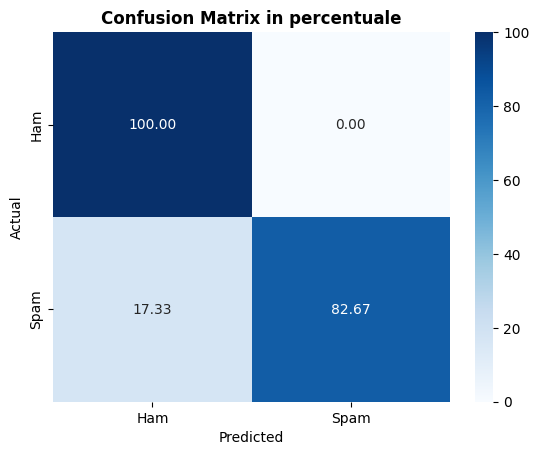

In [149]:
# Confusion Matrix con Valori percentuali
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns




# Vediamo il numero effettivo di Ham e il numero effettivo di Spam nel Test set
print(y_test.value_counts())


### Creazione Confusion Matrix

# Otteniamo i valori delle predizioni in un array (la matrice di confusione) 
mx = metrics.confusion_matrix(y_test, predictions)


# Creiamo un lista vuota che conterrà i valori percentuali
# Sarà una lista di liste e rappresenterà la nostra matrice
perc_cf_mx = []


# Accediamo agli elementi della matrice
for r in range(len(mx)):

    # l è una lista vuota che conterrà i valori di ogni RIGA
    l = []


    for c in range(len(mx)):
        
        # r == 0 -> Riga 0 = ham
        if r == 0:
            # Dividiamo il numero di ham previsti su quelli effettivi (965)
            m = (mx[r][c] / 965) * 100
            
        else:
            # Dividiamo il numero di spam previsti su quelli effettivi (150)
            m = (mx[r][c] / 150) * 100
            

        # Poniamo il rapporto percentuale nelle lista m
        l.append(round(m, 2))
    
    # Aggiungiamo la lista l alla lista perc_cf_mx (la nostra matrice)
    perc_cf_mx.append(l)

# Vediamo i valori percentuali ottenuti
#print(perc_cf_mx)


# Trasformiamo la matrice in un numpy array
perc_cf_mx = np.array(perc_cf_mx)



sns.heatmap(perc_cf_mx,
            annot = True, 
            fmt ='.2f', 
            cmap = 'Blues',
            xticklabels = ['Ham', 'Spam'],
            yticklabels = ['Ham', 'Spam'],
            )
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix in percentuale', fontweight = 'bold')


### 10-Fold Cross Validation

In [150]:
from numpy import mean
from sklearn.model_selection import cross_val_score

# Selezioniamo il modello su cui fare la cross-validation
model = SVC()


# Definiamo i dati su cui efftuiamo l'addestramento 
# e il numero di porzioni 'cv' del dataset di partenza
cv_scores = cross_val_score(model, X, y, cv=10)
print('Accuracy dei classificatori: '+ str(cv_scores) + '\n')


# Media delle performances
print('Media delle performance: ' + str(mean(cv_scores)))

Accuracy dei classificatori: [0.98924731 0.97132616 0.98384201 0.98384201 0.98025135 0.97845601
 0.97486535 0.97666068 0.97127469 0.98563734]

Media delle performance: 0.9795402920149547


### 3.1.3 - Addestramento modello: *Logistic Regression* e Valutazione

In [151]:
# Creiamo e addestriamo il classificatore Logistic Regression
classifier = LogisticRegression()
classifier.fit(X_train.toarray(), y_train)

# Facciamo predizioni sul set di test
predictions = classifier.predict(X_test.toarray())

# Valutiamo le prestazioni del modello
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.97847533632287


In [152]:
# Valutiamo la preformance del classificatore sul test set
from sklearn import metrics


print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       965
        spam       1.00      0.84      0.91       150

    accuracy                           0.98      1115
   macro avg       0.99      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115



### Confusion Matrix

Class
ham     965
spam    150
Name: count, dtype: int64


Text(0.5, 1.0, 'Confusion Matrix in percentuale')

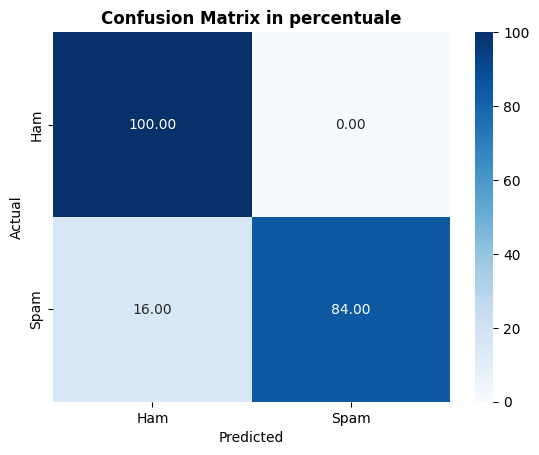

In [153]:
# Confusion Matrix con Valori percentuali
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns




# Vediamo il numero effettivo di Ham e il numero effettivo di Spam nel Test set
print(y_test.value_counts())


### Creazione Confusion Matrix

# Otteniamo i valori delle predizioni in un array (la matrice di confusione) 
mx = metrics.confusion_matrix(y_test, predictions)


# Creiamo un lista vuota che conterrà i valori percentuali
# Sarà una lista di liste e rappresenterà la nostra matrice
perc_cf_mx = []


# Accediamo agli elementi della matrice
for r in range(len(mx)):

    # l è una lista vuota che conterrà i valori di ogni RIGA
    l = []


    for c in range(len(mx)):
        
        # r == 0 -> Riga 0 = ham
        if r == 0:
            # Dividiamo il numero di ham previsti su quelli effettivi (965)
            m = (mx[r][c] / 965) * 100
            
        else:
            # Dividiamo il numero di spam previsti su quelli effettivi (150)
            m = (mx[r][c] / 150) * 100
            

        # Poniamo il rapporto percentuale nelle lista m
        l.append(round(m, 2))
    
    # Aggiungiamo la lista l alla lista perc_cf_mx (la nostra matrice)
    perc_cf_mx.append(l)

# Vediamo i valori percentuali ottenuti
#print(perc_cf_mx)


# Trasformiamo la matrice in un numpy array
perc_cf_mx = np.array(perc_cf_mx)



sns.heatmap(perc_cf_mx,
            annot = True, 
            fmt ='.2f', 
            cmap = 'Blues',
            xticklabels = ['Ham', 'Spam'],
            yticklabels = ['Ham', 'Spam'],
            )
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix in percentuale', fontweight = 'bold')


### 10-Fold Cross Validation

In [154]:
from numpy import mean
from sklearn.model_selection import cross_val_score

# Selezioniamo il modello su cui fare la cross-validation
model = LogisticRegression()


# Definiamo i dati su cui efftuiamo l'addestramento 
# e il numero di porzioni 'cv' del dataset di partenza
cv_scores = cross_val_score(model, X, y, cv=10)
print('Accuracy dei classificatori: '+ str(cv_scores) + '\n')


# Media delle performances
print('Media delle performance: ' + str(mean(cv_scores)))

Accuracy dei classificatori: [0.99462366 0.97491039 0.98384201 0.98922801 0.98384201 0.98204668
 0.98204668 0.98025135 0.98025135 0.98563734]

Media delle performance: 0.9836679472082264


### 3.1.4 - Addestramento modello: *Decision Tree* e Valutazione

In [155]:
# Creiamo e addestriamo il classificatore Decision Tree
classifier = tree.DecisionTreeClassifier()
classifier.fit(X_train.toarray(), y_train)

# Facciamo predizioni sul set di test
predictions = classifier.predict(X_test.toarray())

# Valutiamo le prestazioni del modello
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9748878923766816


In [156]:
# Valutiamo la preformance del classificatore sul test set
from sklearn import metrics


print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       965
        spam       0.96      0.85      0.90       150

    accuracy                           0.97      1115
   macro avg       0.97      0.92      0.94      1115
weighted avg       0.97      0.97      0.97      1115



### Confusion Matrix

Class
ham     965
spam    150
Name: count, dtype: int64


Text(0.5, 1.0, 'Confusion Matrix in percentuale')

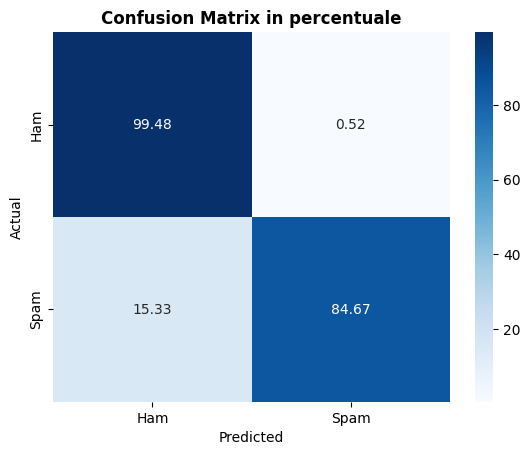

In [157]:
# Confusion Matrix con Valori percentuali
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns




# Vediamo il numero effettivo di Ham e il numero effettivo di Spam nel Test set
print(y_test.value_counts())


### Creazione Confusion Matrix

# Otteniamo i valori delle predizioni in un array (la matrice di confusione) 
mx = metrics.confusion_matrix(y_test, predictions)


# Creiamo un lista vuota che conterrà i valori percentuali
# Sarà una lista di liste e rappresenterà la nostra matrice
perc_cf_mx = []


# Accediamo agli elementi della matrice
for r in range(len(mx)):

    # l è una lista vuota che conterrà i valori di ogni RIGA
    l = []


    for c in range(len(mx)):
        
        # r == 0 -> Riga 0 = ham
        if r == 0:
            # Dividiamo il numero di ham previsti su quelli effettivi (965)
            m = (mx[r][c] / 965) * 100
            
        else:
            # Dividiamo il numero di spam previsti su quelli effettivi (150)
            m = (mx[r][c] / 150) * 100
            

        # Poniamo il rapporto percentuale nelle lista m
        l.append(round(m, 2))
    
    # Aggiungiamo la lista l alla lista perc_cf_mx (la nostra matrice)
    perc_cf_mx.append(l)

# Vediamo i valori percentuali ottenuti
#print(perc_cf_mx)


# Trasformiamo la matrice in un numpy array
perc_cf_mx = np.array(perc_cf_mx)



sns.heatmap(perc_cf_mx,
            annot = True, 
            fmt ='.2f', 
            cmap = 'Blues',
            xticklabels = ['Ham', 'Spam'],
            yticklabels = ['Ham', 'Spam'],
            )
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix in percentuale', fontweight = 'bold')


### 10-Fold Cross Validation

In [158]:
from numpy import mean
from sklearn.model_selection import cross_val_score

# Selezioniamo il modello su cui fare la cross-validation
model = tree.DecisionTreeClassifier()


# Definiamo i dati su cui efftuiamo l'addestramento 
# e il numero di porzioni 'cv' del dataset di partenza
cv_scores = cross_val_score(model, X, y, cv=10)
print('Accuracy dei classificatori: '+ str(cv_scores) + '\n')


# Media delle performances
print('Media delle performance: ' + str(mean(cv_scores)))

Accuracy dei classificatori: [0.98028674 0.97311828 0.97666068 0.97307002 0.97307002 0.97127469
 0.96409336 0.97307002 0.97127469 0.97845601]

Media delle performance: 0.9734374497274827


### 3.1.5 - Addestramento modello: *Dummy Classifier* e Valutazione

In [159]:
# Creiamo e addestriamo il classificatore Dummy Classifier
classifier = DummyClassifier()
classifier.fit(X_train.toarray(), y_train)

# Facciamo predizioni sul set di test
predictions = classifier.predict(X_test.toarray())

# Valutiamo le prestazioni del modello
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8654708520179372


In [160]:
# Valutiamo la preformance del classificatore sul test set
from sklearn import metrics


print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

         ham       0.87      1.00      0.93       965
        spam       0.00      0.00      0.00       150

    accuracy                           0.87      1115
   macro avg       0.43      0.50      0.46      1115
weighted avg       0.75      0.87      0.80      1115



/Users/pio/anaconda3/envs/spamdetection/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/pio/anaconda3/envs/spamdetection/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/pio/anaconda3/envs/spamdetection/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

### Confusion Matrix

Class
ham     965
spam    150
Name: count, dtype: int64


Text(0.5, 1.0, 'Confusion Matrix in percentuale')

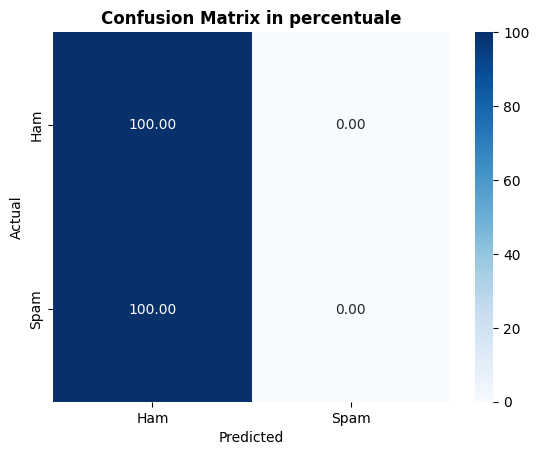

In [161]:
# Confusion Matrix con Valori percentuali
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns




# Vediamo il numero effettivo di Ham e il numero effettivo di Spam nel Test set
print(y_test.value_counts())


### Creazione Confusion Matrix

# Otteniamo i valori delle predizioni in un array (la matrice di confusione) 
mx = metrics.confusion_matrix(y_test, predictions)


# Creiamo un lista vuota che conterrà i valori percentuali
# Sarà una lista di liste e rappresenterà la nostra matrice
perc_cf_mx = []


# Accediamo agli elementi della matrice
for r in range(len(mx)):

    # l è una lista vuota che conterrà i valori di ogni RIGA
    l = []


    for c in range(len(mx)):
        
        # r == 0 -> Riga 0 = ham
        if r == 0:
            # Dividiamo il numero di ham previsti su quelli effettivi (965)
            m = (mx[r][c] / 965) * 100
            
        else:
            # Dividiamo il numero di spam previsti su quelli effettivi (150)
            m = (mx[r][c] / 150) * 100
            

        # Poniamo il rapporto percentuale nelle lista m
        l.append(round(m, 2))
    
    # Aggiungiamo la lista l alla lista perc_cf_mx (la nostra matrice)
    perc_cf_mx.append(l)

# Vediamo i valori percentuali ottenuti
#print(perc_cf_mx)


# Trasformiamo la matrice in un numpy array
perc_cf_mx = np.array(perc_cf_mx)



sns.heatmap(perc_cf_mx,
            annot = True, 
            fmt ='.2f', 
            cmap = 'Blues',
            xticklabels = ['Ham', 'Spam'],
            yticklabels = ['Ham', 'Spam'],
            )
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix in percentuale', fontweight = 'bold')


### 10-Fold Cross Validation

In [162]:
from numpy import mean
from sklearn.model_selection import cross_val_score

# Selezioniamo il modello su cui fare la cross-validation
model = DummyClassifier()


# Definiamo i dati su cui efftuiamo l'addestramento 
# e il numero di porzioni 'cv' del dataset di partenza
cv_scores = cross_val_score(model, X, y, cv=10)
print('Accuracy dei classificatori: '+ str(cv_scores) + '\n')


# Media delle performances
print('Media delle performance: ' + str(mean(cv_scores)))

Accuracy dei classificatori: [0.8655914  0.8655914  0.86714542 0.86714542 0.86714542 0.86535009
 0.86535009 0.86535009 0.86535009 0.86535009]

Media delle performance: 0.8659369510241115


## 3.2 Addestramento dei classificatori - Feature Extraction: TF-IDF (TfidfVectorizer)

### Feature Extraction

In [163]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Import del Classificatore Naive Bayes
from sklearn.naive_bayes import MultinomialNB

# Import del Classificatore Decision Tree
from sklearn import tree

# Import del Classificatore Support Vector Machine
from sklearn.svm import SVC

# Import del Classificatore Logistic Regression
from sklearn.linear_model import LogisticRegression

from sklearn.dummy import DummyClassifier

from sklearn.metrics import accuracy_score

# 'df_stem' è il DataFrame Pandas contenente i dati 'Text' e 'Class'

# Dividiamo i dati in feature (X) e target (y)
X = df_stem['Text']
y = df_stem['Class']

# Estraiamo le feature dai dati testuali utilizzando una Bag of Words
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X)

X.shape

(5572, 6303)

### Train e Test Sets

In [164]:
# Dividiamo i dati in set di addestramento e set di test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Training Data:', X_train.shape)

print('Testing Data: ', X_test.shape)

Training Data: (4457, 6303)
Testing Data:  (1115, 6303)


### 3.2.1 - Addestramento modello: *MultinomialNB* e Valutazione

In [165]:
# Creiamo e addestriamo il classificatore (utilizzando ad esempio il classificatore Naive Bayes)
classifier = MultinomialNB()
classifier.fit(X_train.toarray(), y_train)

# Facciamo predizioni sul set di test
predictions = classifier.predict(X_test.toarray())

# Valutiamo le prestazioni del modello
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9659192825112107


In [166]:
# Valutiamo la preformance del classificatore sul test set
from sklearn import metrics


print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       965
        spam       1.00      0.75      0.85       150

    accuracy                           0.97      1115
   macro avg       0.98      0.87      0.92      1115
weighted avg       0.97      0.97      0.96      1115



### Confusion Matrix

Class
ham     965
spam    150
Name: count, dtype: int64


Text(0.5, 1.0, 'Confusion Matrix in percentuale')

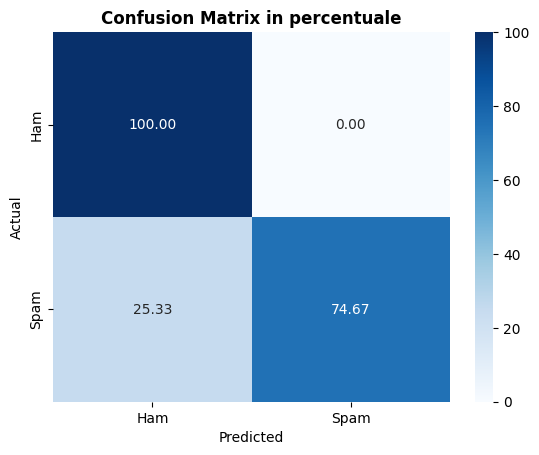

In [167]:
# Confusion Matrix con Valori percentuali
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns




# Vediamo il numero effettivo di Ham e il numero effettivo di Spam nel Test set
print(y_test.value_counts())


### Creazione Confusion Matrix

# Otteniamo i valori delle predizioni in un array (la matrice di confusione) 
mx = metrics.confusion_matrix(y_test, predictions)


# Creiamo un lista vuota che conterrà i valori percentuali
# Sarà una lista di liste e rappresenterà la nostra matrice
perc_cf_mx = []


# Accediamo agli elementi della matrice
for r in range(len(mx)):

    # l è una lista vuota che conterrà i valori di ogni RIGA
    l = []


    for c in range(len(mx)):
        
        # r == 0 -> Riga 0 = ham
        if r == 0:
            # Dividiamo il numero di ham previsti su quelli effettivi (965)
            m = (mx[r][c] / 965) * 100
            
        else:
            # Dividiamo il numero di spam previsti su quelli effettivi (150)
            m = (mx[r][c] / 150) * 100
            

        # Poniamo il rapporto percentuale nelle lista m
        l.append(round(m, 2))
    
    # Aggiungiamo la lista l alla lista perc_cf_mx (la nostra matrice)
    perc_cf_mx.append(l)

# Vediamo i valori percentuali ottenuti
#print(perc_cf_mx)


# Trasformiamo la matrice in un numpy array
perc_cf_mx = np.array(perc_cf_mx)



sns.heatmap(perc_cf_mx,
            annot = True, 
            fmt ='.2f', 
            cmap = 'Blues',
            xticklabels = ['Ham', 'Spam'],
            yticklabels = ['Ham', 'Spam'],
            )
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix in percentuale', fontweight = 'bold')


### 10-Fold Cross Validation

In [168]:
from numpy import mean
from sklearn.model_selection import cross_val_score

# Selezioniamo il modello su cui fare la cross-validation
model = MultinomialNB()


# Definiamo i dati su cui efftuiamo l'addestramento 
# e il numero di porzioni 'cv' del dataset di partenza
cv_scores = cross_val_score(model, X, y, cv=10)
print('Accuracy dei classificatori: '+ str(cv_scores) + '\n')


# Media delle performances
print('Media delle performance: ' + str(mean(cv_scores)))

Accuracy dei classificatori: [0.98207885 0.97132616 0.96409336 0.97666068 0.96229803 0.97486535
 0.96409336 0.96947935 0.96229803 0.97845601]

Media delle performance: 0.9705649183091702


### 3.2.2 - Addestramento modello: *Support Vector Machine* e Valutazione

In [169]:
# Creiamo e addestriamo il classificatore SVM
classifier = SVC()
classifier.fit(X_train.toarray(), y_train)

# Facciamo predizioni sul set di test
predictions = classifier.predict(X_test.toarray())

# Valutiamo le prestazioni del modello
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.97847533632287


In [170]:
# Valutiamo la preformance del classificatore sul test set
from sklearn import metrics


print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       965
        spam       0.99      0.85      0.91       150

    accuracy                           0.98      1115
   macro avg       0.98      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115



### Confusion Matrix

Class
ham     965
spam    150
Name: count, dtype: int64


Text(0.5, 1.0, 'Confusion Matrix in percentuale')

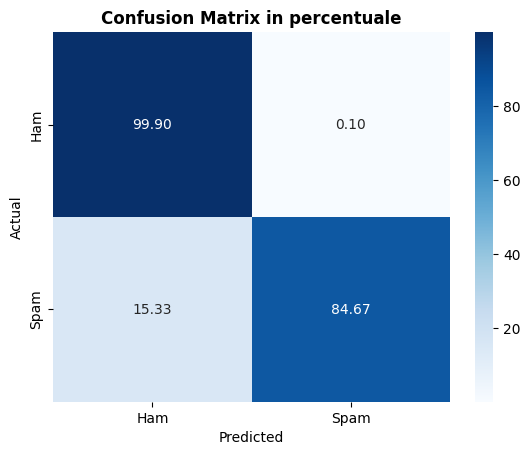

In [171]:
# Confusion Matrix con Valori percentuali
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns




# Vediamo il numero effettivo di Ham e il numero effettivo di Spam nel Test set
print(y_test.value_counts())


### Creazione Confusion Matrix

# Otteniamo i valori delle predizioni in un array (la matrice di confusione) 
mx = metrics.confusion_matrix(y_test, predictions)


# Creiamo un lista vuota che conterrà i valori percentuali
# Sarà una lista di liste e rappresenterà la nostra matrice
perc_cf_mx = []


# Accediamo agli elementi della matrice
for r in range(len(mx)):

    # l è una lista vuota che conterrà i valori di ogni RIGA
    l = []


    for c in range(len(mx)):
        
        # r == 0 -> Riga 0 = ham
        if r == 0:
            # Dividiamo il numero di ham previsti su quelli effettivi (965)
            m = (mx[r][c] / 965) * 100
            
        else:
            # Dividiamo il numero di spam previsti su quelli effettivi (150)
            m = (mx[r][c] / 150) * 100
            

        # Poniamo il rapporto percentuale nelle lista m
        l.append(round(m, 2))
    
    # Aggiungiamo la lista l alla lista perc_cf_mx (la nostra matrice)
    perc_cf_mx.append(l)

# Vediamo i valori percentuali ottenuti
#print(perc_cf_mx)


# Trasformiamo la matrice in un numpy array
perc_cf_mx = np.array(perc_cf_mx)



sns.heatmap(perc_cf_mx,
            annot = True, 
            fmt ='.2f', 
            cmap = 'Blues',
            xticklabels = ['Ham', 'Spam'],
            yticklabels = ['Ham', 'Spam'],
            )
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix in percentuale', fontweight = 'bold')


### 10-Fold Cross Validation

In [172]:
from numpy import mean
from sklearn.model_selection import cross_val_score

# Selezioniamo il modello su cui fare la cross-validation
model = SVC()


# Definiamo i dati su cui efftuiamo l'addestramento 
# e il numero di porzioni 'cv' del dataset di partenza
cv_scores = cross_val_score(model, X, y, cv=10)
print('Accuracy dei classificatori: '+ str(cv_scores) + '\n')


# Media delle performances
print('Media delle performance: ' + str(mean(cv_scores)))

Accuracy dei classificatori: [0.98924731 0.96953405 0.98025135 0.98563734 0.97486535 0.97845601
 0.97307002 0.97845601 0.97666068 0.98025135]

Media delle performance: 0.9786429476908426


### 3.2.3 - Addestramento modello: *Logistic Regression* e Valutazione

In [173]:
# Creiamo e addestriamo il classificatore Logistic Regression
classifier = LogisticRegression()
classifier.fit(X_train.toarray(), y_train)

# Facciamo predizioni sul set di test
predictions = classifier.predict(X_test.toarray())

# Valutiamo le prestazioni del modello
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.957847533632287


In [174]:
# Valutiamo la preformance del classificatore sul test set
from sklearn import metrics


print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       965
        spam       0.96      0.71      0.82       150

    accuracy                           0.96      1115
   macro avg       0.96      0.85      0.90      1115
weighted avg       0.96      0.96      0.96      1115



### Confusion Matrix

Class
ham     965
spam    150
Name: count, dtype: int64


Text(0.5, 1.0, 'Confusion Matrix in percentuale')

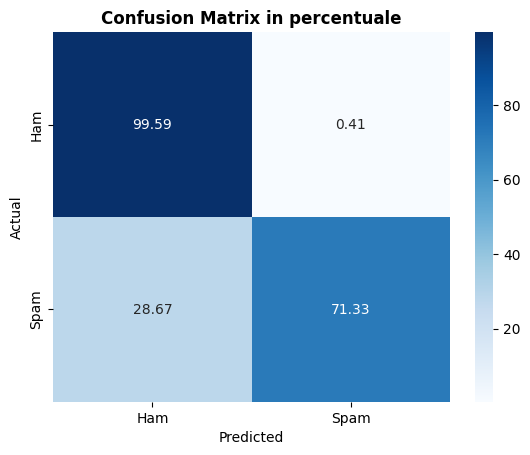

In [175]:
# Confusion Matrix con Valori percentuali
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns




# Vediamo il numero effettivo di Ham e il numero effettivo di Spam nel Test set
print(y_test.value_counts())


### Creazione Confusion Matrix

# Otteniamo i valori delle predizioni in un array (la matrice di confusione) 
mx = metrics.confusion_matrix(y_test, predictions)


# Creiamo un lista vuota che conterrà i valori percentuali
# Sarà una lista di liste e rappresenterà la nostra matrice
perc_cf_mx = []


# Accediamo agli elementi della matrice
for r in range(len(mx)):

    # l è una lista vuota che conterrà i valori di ogni RIGA
    l = []


    for c in range(len(mx)):
        
        # r == 0 -> Riga 0 = ham
        if r == 0:
            # Dividiamo il numero di ham previsti su quelli effettivi (965)
            m = (mx[r][c] / 965) * 100
            
        else:
            # Dividiamo il numero di spam previsti su quelli effettivi (150)
            m = (mx[r][c] / 150) * 100
            

        # Poniamo il rapporto percentuale nelle lista m
        l.append(round(m, 2))
    
    # Aggiungiamo la lista l alla lista perc_cf_mx (la nostra matrice)
    perc_cf_mx.append(l)

# Vediamo i valori percentuali ottenuti
#print(perc_cf_mx)


# Trasformiamo la matrice in un numpy array
perc_cf_mx = np.array(perc_cf_mx)



sns.heatmap(perc_cf_mx,
            annot = True, 
            fmt ='.2f', 
            cmap = 'Blues',
            xticklabels = ['Ham', 'Spam'],
            yticklabels = ['Ham', 'Spam'],
            )
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix in percentuale', fontweight = 'bold')


### 10-Fold Cross Validation

In [176]:
from numpy import mean
from sklearn.model_selection import cross_val_score

# Selezioniamo il modello su cui fare la cross-validation
model = LogisticRegression()


# Definiamo i dati su cui efftuiamo l'addestramento 
# e il numero di porzioni 'cv' del dataset di partenza
cv_scores = cross_val_score(model, X, y, cv=10)
print('Accuracy dei classificatori: '+ str(cv_scores) + '\n')


# Media delle performances
print('Media delle performance: ' + str(mean(cv_scores)))

Accuracy dei classificatori: [0.96236559 0.96236559 0.96229803 0.97307002 0.96588869 0.96409336
 0.95870736 0.96947935 0.96229803 0.97127469]

Media delle performance: 0.9651840698056023


### 3.2.4 - Addestramento modello: *Decision Tree* e Valutazione

In [177]:
# Creiamo e addestriamo il classificatore Decision Tree
classifier = tree.DecisionTreeClassifier()
classifier.fit(X_train.toarray(), y_train)

# Facciamo predizioni sul set di test
predictions = classifier.predict(X_test.toarray())

# Valutiamo le prestazioni del modello
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9659192825112107


In [178]:
# Valutiamo la preformance del classificatore sul test set
from sklearn import metrics


print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

         ham       0.98      0.98      0.98       965
        spam       0.86      0.89      0.88       150

    accuracy                           0.97      1115
   macro avg       0.92      0.94      0.93      1115
weighted avg       0.97      0.97      0.97      1115



### Confusion Matrix

Class
ham     965
spam    150
Name: count, dtype: int64


Text(0.5, 1.0, 'Confusion Matrix in percentuale')

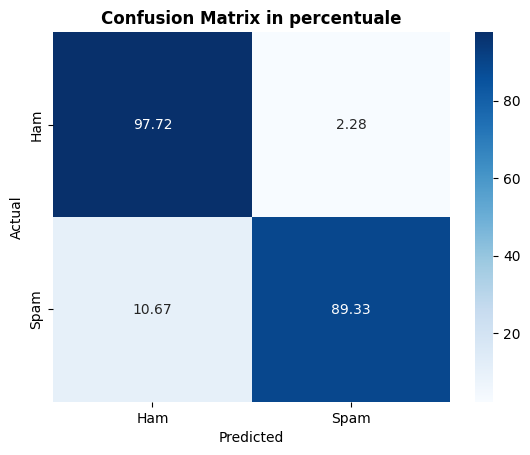

In [179]:
# Confusion Matrix con Valori percentuali
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns




# Vediamo il numero effettivo di Ham e il numero effettivo di Spam nel Test set
print(y_test.value_counts())


### Creazione Confusion Matrix

# Otteniamo i valori delle predizioni in un array (la matrice di confusione) 
mx = metrics.confusion_matrix(y_test, predictions)


# Creiamo un lista vuota che conterrà i valori percentuali
# Sarà una lista di liste e rappresenterà la nostra matrice
perc_cf_mx = []


# Accediamo agli elementi della matrice
for r in range(len(mx)):

    # l è una lista vuota che conterrà i valori di ogni RIGA
    l = []


    for c in range(len(mx)):
        
        # r == 0 -> Riga 0 = ham
        if r == 0:
            # Dividiamo il numero di ham previsti su quelli effettivi (965)
            m = (mx[r][c] / 965) * 100
            
        else:
            # Dividiamo il numero di spam previsti su quelli effettivi (150)
            m = (mx[r][c] / 150) * 100
            

        # Poniamo il rapporto percentuale nelle lista m
        l.append(round(m, 2))
    
    # Aggiungiamo la lista l alla lista perc_cf_mx (la nostra matrice)
    perc_cf_mx.append(l)

# Vediamo i valori percentuali ottenuti
#print(perc_cf_mx)


# Trasformiamo la matrice in un numpy array
perc_cf_mx = np.array(perc_cf_mx)



sns.heatmap(perc_cf_mx,
            annot = True, 
            fmt ='.2f', 
            cmap = 'Blues',
            xticklabels = ['Ham', 'Spam'],
            yticklabels = ['Ham', 'Spam'],
            )
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix in percentuale', fontweight = 'bold')


### 10-Fold Cross Validation

In [180]:
from numpy import mean
from sklearn.model_selection import cross_val_score

# Selezioniamo il modello su cui fare la cross-validation
model = tree.DecisionTreeClassifier()


# Definiamo i dati su cui efftuiamo l'addestramento 
# e il numero di porzioni 'cv' del dataset di partenza
cv_scores = cross_val_score(model, X, y, cv=10)
print('Accuracy dei classificatori: '+ str(cv_scores) + '\n')


# Media delle performances
print('Media delle performance: ' + str(mean(cv_scores)))

Accuracy dei classificatori: [0.96953405 0.96774194 0.98204668 0.97307002 0.97666068 0.96768402
 0.9443447  0.96947935 0.96409336 0.97127469]

Media delle performance: 0.9685929486560749


### 3.2.5 - Addestramento modello: *Dummy Classifier* e Valutazione

In [181]:
# Creiamo e addestriamo il classificatore Dummy Classifier
classifier = DummyClassifier()
classifier.fit(X_train.toarray(), y_train)

# Facciamo predizioni sul set di test
predictions = classifier.predict(X_test.toarray())

# Valutiamo le prestazioni del modello
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8654708520179372


In [182]:
# Valutiamo la preformance del classificatore sul test set
from sklearn import metrics


print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

         ham       0.87      1.00      0.93       965
        spam       0.00      0.00      0.00       150

    accuracy                           0.87      1115
   macro avg       0.43      0.50      0.46      1115
weighted avg       0.75      0.87      0.80      1115



/Users/pio/anaconda3/envs/spamdetection/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/pio/anaconda3/envs/spamdetection/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/pio/anaconda3/envs/spamdetection/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

### Confusion Matrix

Class
ham     965
spam    150
Name: count, dtype: int64


Text(0.5, 1.0, 'Confusion Matrix in percentuale')

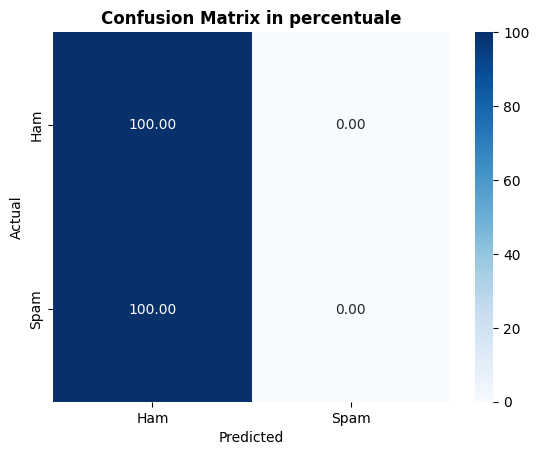

In [183]:
# Confusion Matrix con Valori percentuali
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns




# Vediamo il numero effettivo di Ham e il numero effettivo di Spam nel Test set
print(y_test.value_counts())


### Creazione Confusion Matrix

# Otteniamo i valori delle predizioni in un array (la matrice di confusione) 
mx = metrics.confusion_matrix(y_test, predictions)


# Creiamo un lista vuota che conterrà i valori percentuali
# Sarà una lista di liste e rappresenterà la nostra matrice
perc_cf_mx = []


# Accediamo agli elementi della matrice
for r in range(len(mx)):

    # l è una lista vuota che conterrà i valori di ogni RIGA
    l = []


    for c in range(len(mx)):
        
        # r == 0 -> Riga 0 = ham
        if r == 0:
            # Dividiamo il numero di ham previsti su quelli effettivi (965)
            m = (mx[r][c] / 965) * 100
            
        else:
            # Dividiamo il numero di spam previsti su quelli effettivi (150)
            m = (mx[r][c] / 150) * 100
            

        # Poniamo il rapporto percentuale nelle lista m
        l.append(round(m, 2))
    
    # Aggiungiamo la lista l alla lista perc_cf_mx (la nostra matrice)
    perc_cf_mx.append(l)

# Vediamo i valori percentuali ottenuti
#print(perc_cf_mx)


# Trasformiamo la matrice in un numpy array
perc_cf_mx = np.array(perc_cf_mx)



sns.heatmap(perc_cf_mx,
            annot = True, 
            fmt ='.2f', 
            cmap = 'Blues',
            xticklabels = ['Ham', 'Spam'],
            yticklabels = ['Ham', 'Spam'],
            )
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix in percentuale', fontweight = 'bold')


### 10-Fold Cross Validation

In [184]:
from numpy import mean
from sklearn.model_selection import cross_val_score

# Selezioniamo il modello su cui fare la cross-validation
model = DummyClassifier()


# Definiamo i dati su cui efftuiamo l'addestramento 
# e il numero di porzioni 'cv' del dataset di partenza
cv_scores = cross_val_score(model, X, y, cv=10)
print('Accuracy dei classificatori: '+ str(cv_scores) + '\n')


# Media delle performances
print('Media delle performance: ' + str(mean(cv_scores)))

Accuracy dei classificatori: [0.8655914  0.8655914  0.86714542 0.86714542 0.86714542 0.86535009
 0.86535009 0.86535009 0.86535009 0.86535009]

Media delle performance: 0.8659369510241115


# 4. Accuracy dei 20 classificatori

In [185]:
# Creaimo un dataframe con pandas per ottenere la nostra tabella con tutti i classificatori
import pandas as pd

tab = pd.DataFrame(columns = ['DummyClassifier','MultinomialNB', 'Support Vector Machine', 'Logistic Regression', 'Decision Tree'],
                   index = ['Lemmatization + CountVectorizer', 'Lemmatization + TfidfVectorizer',
                            'Stemming + CountVectorizer', 'Stemming + TfidfVectorizer'])

In [186]:
# Inseriamo i valori all'interno di ogni colonna
tab['DummyClassifier'] = ['86.547%', '86.547%','86.547%','86.547%']
tab['MultinomialNB'] = ['97.399%', '96.233%', '97.578%', '96.592%']
tab['Support Vector Machine'] = ['97.758%', '97.847%', '97.668%', '97.847%']
tab['Logistic Regression'] = ['97.758%', '95.336%', '97.758%', '95.874%' ]
tab['Decision Tree'] = ['97.130%', '97.040%', '97.309%', '96.502%']

In [187]:
# Visualizziamo la tabella con l'accuracy

tab

,DummyClassifier,MultinomialNB,Support Vector Machine,Logistic Regression,Decision Tree
Lemmatization + CountVectorizer,86.547%,97.399%,97.758%,97.758%,97.130%
Lemmatization + TfidfVectorizer,86.547%,96.233%,97.847%,95.336%,97.040%
Stemming + CountVectorizer,86.547%,97.578%,97.668%,97.758%,97.309%
Stemming + TfidfVectorizer,86.547%,96.592%,97.847%,95.874%,96.502%


# 5. Gestione dello sbilanciamento tra classi

Nelle sezioni in cui è avvenuto l'addestramento dei classificatori, abbiamo sfruttato un dataset con classi sbilanciate.

Per gestire lo sbilanciamento creiamo piccoli dataset di egual misura per i messaggi ham, avvicinando il numero di occorrenze a quello di spam.


Questo ci ha permesso di ottenere 7 classificatori e vedere le loro performance con classi bilanciate, in modo tale da poterle confrontare con le performance dei classificatori addestrati con le classi sbilanciate.


Infine, abbiamo implementato una **Strategia di Hardvoting** impiegando questi 7 classificatori. Combinando i vari esiti, il risultato più restituito sarà quello finale.

### Creazione dataset bilanciati

In [35]:
# Poiché abbiamo 4825 righe di ham, le dividiamo per 7 
# Andiamo a ottenere 7 suddivisioni di 689 righe di messaggi Ham ciascuna


# Ciclo per ottenere le suddivisioni come liste
index = 689
count = 0
suddivisioni = []



for i in range(0, 7):

    # Suddivisioni sarà così una lista di liste, dove ciascuna sarà lunga 689 (ovvero il numero di messaggi)
    suddivisioni.append(ham_msg[count:index])

    count = index
    index = (count + 689)


In [36]:
# Creiamo dapprima un dataframe per tutti i messaggi di spam
# questo sarà poi unito alle suddivisioni create in precedenza
import pandas as pd

data_spam = pd.DataFrame(columns=['Text', 'Class'])


txt = []
clas = []

for i in range(len(df)):
    if df.loc[i]['Class'] == 'spam':
        txt.append(df.loc[i]['Text'].strip("'"))
        clas.append(df.loc[i]['Class'])


data_spam['Text'] = txt
data_spam['Class'] = clas

In [37]:
# Creiamo i 7 dataframe diversi unendoli con quello spam, ovvero 'data_spam'
name_dataframes = ['data1', 'data2', 'data3', 'data4', 'data5', 'data6', 'data7']


# n è il contatore che assumerà valore da 0 a 6
# rendendo possibile l'accesso alla lista con i nomi dei dataframe
n = 0


for i in suddivisioni:
    data = pd.DataFrame()
    data['Text'] = i

    for c in range(len(data)):
        data['Class'] = 'ham'
    

    # Uniamo il dataframe contenente solo messaggi 'ham' - creato nell'iterazione 
    # con il dataframe contenenti gli spam
    data = pd.concat([data, data_spam], ignore_index=True)  
    
    # Vediamo il numero di occorrenze di ciascuna classe in ogn dafaframe
    print(data['Class'].value_counts())

    # Salviamo il dataframe, appena concatenato, come variabile
    # usando il nome presente nella lista 'name_dataframes'
    locals()[name_dataframes[n]] = data

    n += 1


Class
spam    747
ham     689
Name: count, dtype: int64
Class
spam    747
ham     689
Name: count, dtype: int64
Class
spam    747
ham     689
Name: count, dtype: int64
Class
spam    747
ham     689
Name: count, dtype: int64
Class
spam    747
ham     689
Name: count, dtype: int64
Class
spam    747
ham     689
Name: count, dtype: int64
Class
spam    747
ham     689
Name: count, dtype: int64


Dopo aver creato i nostri 7 dataframe con classi bilanciate, andiamo a fare l'addestramento dei 7 classificatori scegliendo la combinazione che nelle sezioni precedenti ha avuto l'accuracy migliore:

**Lemmatization + TfidfVectorizer con il SVM**

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /Users/pio/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /Users/pio/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/pio/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/pio/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /Users/pio/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /Users/pio/nltk_data...
[nltk_data]    |   Pack


Metriche Classificatore 1
              precision    recall  f1-score   support

         ham       0.92      0.99      0.96       131
        spam       0.99      0.93      0.96       157

    accuracy                           0.96       288
   macro avg       0.96      0.96      0.96       288
weighted avg       0.96      0.96      0.96       288



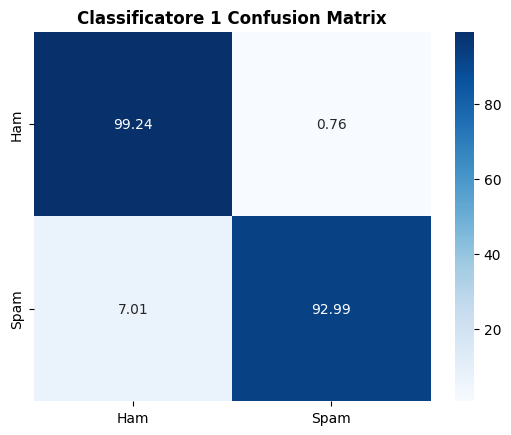

Accuracy del classificatore 1: 0.9583333333333334

Metriche Classificatore 2
              precision    recall  f1-score   support

         ham       0.92      0.99      0.96       131
        spam       0.99      0.93      0.96       157

    accuracy                           0.96       288
   macro avg       0.96      0.96      0.96       288
weighted avg       0.96      0.96      0.96       288



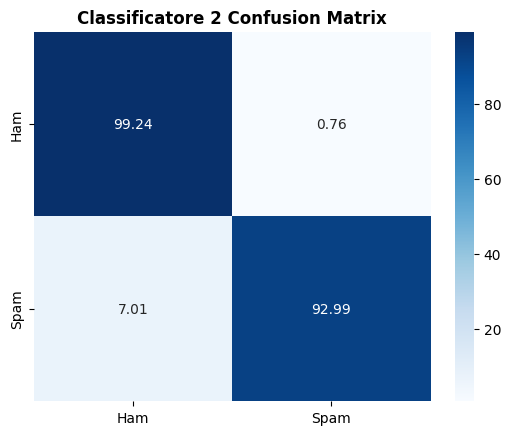

Accuracy del classificatore 2: 0.9583333333333334

Metriche Classificatore 3
              precision    recall  f1-score   support

         ham       0.91      0.97      0.94       131
        spam       0.97      0.92      0.95       157

    accuracy                           0.94       288
   macro avg       0.94      0.95      0.94       288
weighted avg       0.95      0.94      0.94       288



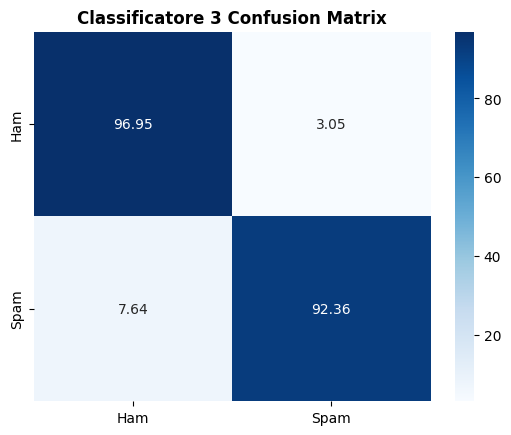

Accuracy del classificatore 3: 0.9444444444444444

Metriche Classificatore 4
              precision    recall  f1-score   support

         ham       0.93      0.99      0.96       131
        spam       0.99      0.94      0.96       157

    accuracy                           0.96       288
   macro avg       0.96      0.96      0.96       288
weighted avg       0.96      0.96      0.96       288



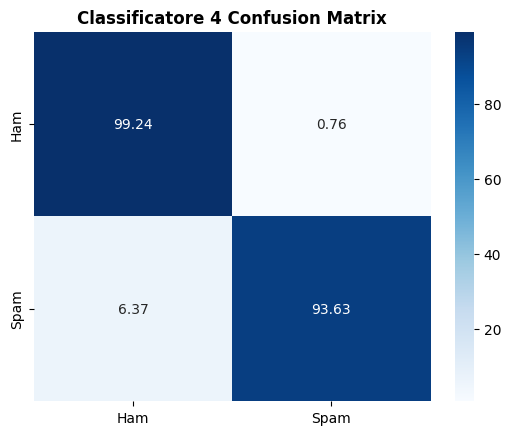

Accuracy del classificatore 4: 0.9618055555555556

Metriche Classificatore 5
              precision    recall  f1-score   support

         ham       0.91      0.98      0.95       131
        spam       0.99      0.92      0.95       157

    accuracy                           0.95       288
   macro avg       0.95      0.95      0.95       288
weighted avg       0.95      0.95      0.95       288



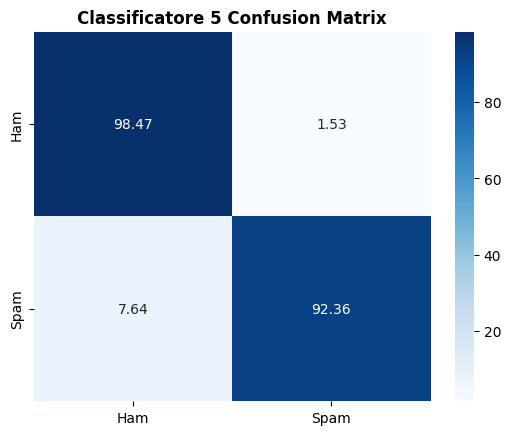

Accuracy del classificatore 5: 0.9513888888888888

Metriche Classificatore 6
              precision    recall  f1-score   support

         ham       0.92      0.98      0.95       131
        spam       0.99      0.93      0.96       157

    accuracy                           0.95       288
   macro avg       0.95      0.96      0.95       288
weighted avg       0.96      0.95      0.95       288



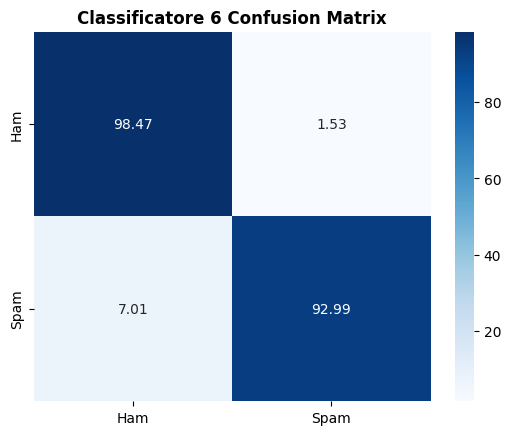

Accuracy del classificatore 6: 0.9548611111111112

Metriche Classificatore 7
              precision    recall  f1-score   support

         ham       0.91      0.99      0.95       131
        spam       0.99      0.92      0.95       157

    accuracy                           0.95       288
   macro avg       0.95      0.95      0.95       288
weighted avg       0.95      0.95      0.95       288



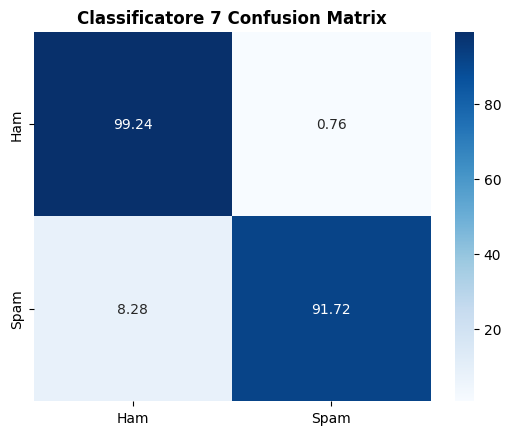

Accuracy del classificatore 7: 0.9513888888888888


In [38]:
# Scegliamo di usare la combinazione Lemmatization + TfidfVectorizer con il SVM
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
# Import del Classificatore Support Vector Machine
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Download nltk
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
import seaborn as sns

nltk.download('all')



# Loop per il training dei 7 classificatori

# Definiamo i nomi che avranno i 7 classificatori
classifiers = ['classifier1', 'classifier2', 'classifier3', 'classifier4',
               'classifier5','classifier6','classifier7']

# Lista con tutti i dataset bilanciati
datasets = [data1, data2, data3, data4, data5, data6, data7]


# Raccogliamo le accuracy dei classificatori che addestreremo
classifiers_accuracies = []


for i in range(len(datasets)):

    # Lemmatization

    # Creiamo una lista contenente testi
    text = list(datasets[i]['Text'])

    # Loop per il preprocessing
    lemmatizer = WordNetLemmatizer()

    corpus = []

    for c in range(len(text)):

        # Rimuoviamo i caratteri speciali
        r = re.sub('[^a-zA-Z]', ' ', text[c])

        # Rendiamo tutto minuscolo
        r = r.lower()

        # Tokenizziamo le parole
        r = r.split()

        # Rimuoviamo le stopwords
        r = [word for word in r if word not in stopwords.words('english')]

        # Lemmatizzation
        r = [lemmatizer.lemmatize(word) for word in r]

        r = ' '.join(r)

        corpus.append(r)
    
    
    # Andiamo a sostituire il testo dopo aver fatto la lemmatization
    # All'interno del relativo dataframe
    datasets[i]['Text'] = corpus
    


    ## TRAINING
    # Dividiamo i dati in feature (X) e target (y)
    
    X = datasets[i]['Text']
    y = datasets[i]['Class']

    # Estraiamo le feature con Il TfidfVectorizer
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(X)


    # Dividiamo i dati in set di addestramento e set di test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    # Creiamo e addestriamo il classificatore
    classifier = SVC()
    classifier.fit(X_train.toarray(), y_train)


    # Facciamo predizioni sul set di test
    predictions = classifier.predict(X_test.toarray())


    # Valutiamo le prestazioni del modello
    accuracy = accuracy_score(y_test, predictions)
    classifiers_accuracies.append(accuracy)


    # Valutiamo la preformance del classificatore sul test set
    print(f'\nMetriche Classificatore {i+1}')
    print(metrics.classification_report(y_test, predictions))



    
    # Matrice di confusione per il classificatore n-simo
    # Otteniamo i valori delle predizioni in un array (la matrice di confusione) 
    mx = metrics.confusion_matrix(y_test, predictions)


    # Creiamo un lista vuota che conterrà i valori percentuali
    # Sarà una lista di liste e rappresenterà la nostra matrice
    perc_cf_mx = []


    # Accediamo agli elementi della matrice
    for r in range(len(mx)):

        # l è una lista vuota che conterrà i valori di ogni RIGA
        l = []


        for c in range(len(mx)):
            
            # r == 0 -> Riga 0 = ham
            if r == 0:
                # Dividiamo il numero di ham previsti su quelli effettivi (131)
                m = (mx[r][c] / 131) * 100
                
            else:
                # Dividiamo il numero di spam previsti su quelli effettivi (157)
                m = (mx[r][c] / 157) * 100
                

            # Poniamo il rapporto percentuale nelle lista m
            l.append(round(m, 2))
        
        # Aggiungiamo la lista l alla lista perc_cf_mx (la nostra matrice)
        perc_cf_mx.append(l)

    # Vediamo i valori percentuali ottenuti
    #print(perc_cf_mx)


    # Trasformiamo la matrice in un numpy array
    perc_cf_mx = np.array(perc_cf_mx)



    sns.heatmap(perc_cf_mx,
                annot = True, 
                fmt ='.2f', 
                cmap = 'Blues',
                xticklabels = ['Ham', 'Spam'],
                yticklabels = ['Ham', 'Spam'],
                )
    plt.title(f'Classificatore {i+1} Confusion Matrix', fontweight = 'bold')
    plt.show()



    # Salviamo il modello con il nome previsto nella lista 'classifiers'
    locals()[classifiers[i]] = classifier

    # Vediamo l'accuracy del modello
    print(f'Accuracy del classificatore {i+1}: {accuracy}')

    


In [39]:
# Creaimo un dataframe con le accuracy dei 7 classificatori
accuracies = [str(round(a * 100, 2)) + '%' for a in classifiers_accuracies]


acc_seven = pd.DataFrame(accuracies, 
                         columns = ['Accuracy'],
                         index = ['classifier1', 'classifier2', 'classifier3', 'classifier4',
                                  'classifier5','classifier6','classifier7'])

# Visualizziamolo
acc_seven

,Accuracy
classifier1,95.83%
classifier2,95.83%
classifier3,94.44%
classifier4,96.18%
classifier5,95.14%
classifier6,95.49%
classifier7,95.14%


### Strategia di Hardvoting - Test con Input da tastiera

In [40]:
# Facciamo predizioni su una stringa di prova
from colorama import Fore, Style


# Ora possiamo definire una lista con i 7 classificatori
trained_classifiers = [classifier1, classifier2, classifier3, classifier4,
                       classifier5, classifier6, classifier7]


# Test su messaggi in input da utente
while True:

    # Messaggio da verificare
    prova = input('Write the SMS to verify: ')

    if prova.upper() == 'STOP':
        break

    # Lista che conterrà tutte le predizioni dei 7 classificatori
    pred_balanced_classifiers = []


    # Effettuiamo la previsione sul messaggio 'prova' per ogni classificatore
    for i in range(len(classifiers)):


        # Riprendiamo il dataframe su cui abbiamo fatto già la lemmatizzation
        X = datasets[i]['Text']


        # Estraiamo le feature diverse per ogni X,
        # quindi un vectorizer diverso per ogni classificatore
        vectorizer = TfidfVectorizer()
        X = vectorizer.fit_transform(X)    


        # Vettorizziamo il nostro messaggio di prova
        prova_vectorized = vectorizer.transform([prova])


        # Il classificatore preso dalla lista 'trained_classifiers' effettua la previsione
        prediction = trained_classifiers[i].predict(prova_vectorized.toarray())
        

        # Salviamo i risultati del classificatore
        pred_balanced_classifiers.append(prediction[0])


        # Vediamo l'esito del classificatore
        print(f'Il classificatore {i+1} restituisce come risultato: ' + prediction[0] + '\n')


    # Vediamo tutti i risultati
    print('Esiti finali: ' + str(pred_balanced_classifiers) + '\n')


    # Esito Hardvoting
    n_ris_spam = pred_balanced_classifiers.count('spam')
    n_ris_ham = pred_balanced_classifiers.count('ham')


    if n_ris_spam > n_ris_ham:
        print(f"L'esito finale con la strategia di Hardvoting è: {Fore.RED}SPAM{Style.RESET_ALL}")
    else:
        print(f"L'esito finale con la strategia di Hardvoting è: {Fore.GREEN}HAM{Style.RESET_ALL}")


Il classificatore 1 restituisce come risultato: ham

Il classificatore 2 restituisce come risultato: ham

Il classificatore 3 restituisce come risultato: ham

Il classificatore 4 restituisce come risultato: ham

Il classificatore 5 restituisce come risultato: ham

Il classificatore 6 restituisce come risultato: ham

Il classificatore 7 restituisce come risultato: ham

Esiti finali: ['ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham']

L'esito finale con la strategia di Hardvoting è: HAM


## 5.1 Importiamo un altro dataset con messaggi di spam per testare i 7 classificatori

### Link al dataset: https://huggingface.co/datasets/Deysi/spam-detection-dataset?row=11

In [24]:
# Dopo aver fatto il download del file
import pandas as pd 

# Salviamo il file parquet come un DataFrame Pandas
spam_text_test = pd.read_parquet('./data_spam_test.parquet')

# Visualizziamolo
spam_text_test.head()

,text,label
0,hey I am looking for Xray baggage datasets can...,not_spam
1,"""Get rich quick! Make millions in just days wi...",spam
2,URGENT MESSAGE: YOU WON'T BELIEVE WHAT WE HAVE...,spam
3,[Google AI Blog: Contributing Data to Deepfake...,not_spam
4,Trying to see if anyone already has timestamps...,not_spam


In [10]:
len(spam_text_test)

8175

In [25]:
# Sostituiamo la label 'not_spam' con 'ham'

for c in range(len(spam_text_test)):
    if spam_text_test.loc[c]['label'] == 'not_spam':
        spam_text_test.loc[c]['label'] = 'ham'

spam_text_test

,text,label
0,hey I am looking for Xray baggage datasets can...,ham
1,"""Get rich quick! Make millions in just days wi...",spam
2,URGENT MESSAGE: YOU WON'T BELIEVE WHAT WE HAVE...,spam
3,[Google AI Blog: Contributing Data to Deepfake...,ham
4,Trying to see if anyone already has timestamps...,ham
...,...,...
8170,"Hi all,\n\nWe create datasets by taking pictur...",ham
8171,DEALS! DEALS! DEALS!\n\nHey peeps! You won't b...,spam
8172,Hi\n\nI am working on a project and need penal...,ham
8173,Do you want to BLOW UP your social media follo...,spam


In [12]:
# Vediamo la suddivisione in classi
spam_text_test['label'].value_counts()

label
spam    4125
ham     4050
Name: count, dtype: int64

### Applichiamo la Lemmatizzation sul dataset

In [26]:
# Lemmatization

nltk.download('all')

# Creiamo una lista contenente testi
text = list(spam_text_test['text'])

# Loop per il preprocessing
lemmatizer = WordNetLemmatizer()

corpus = []

for c in range(len(text)):

    # Rimuoviamo i caratteri speciali
    r = re.sub('[^a-zA-Z]', ' ', text[c])

    # Rendiamo tutto minuscolo
    r = r.lower()

    # Tokenizziamo le parole
    r = r.split()

    # Rimuoviamo le stopwords
    r = [word for word in r if word not in stopwords.words('english')]

    # Lemmatizzation
    r = [lemmatizer.lemmatize(word) for word in r]

    r = ' '.join(r)

    corpus.append(r)


# Andiamo a sostituire il testo dopo aver fatto la lemmatization
# All'interno del relativo dataframe
spam_text_test['text'] = corpus

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /Users/pio/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /Users/pio/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/pio/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/pio/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /Users/pio/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /Users/pio/nltk_data...
[nltk_data]    |   Pack

In [27]:
# Visualizziamo il dataset con i testi modificati dalla Lemmatizzation
spam_text_test

,text,label
0,hey looking xray baggage datasets provide,ham
1,get rich quick make million day new revolution...,spam
2,urgent message believe offer hey yeah eye read...,spam
3,google ai blog contributing data deepfake dete...,ham
4,trying see anyone already timestamps key event...,ham
...,...,...
8170,hi create datasets taking picture specific obj...,ham
8171,deal deal deal hey peep believe amazing deal g...,spam
8172,hi working project need penalty conceding scor...,ham
8173,want blow social medium follower instantly loo...,spam


### Test dei 7 classificatori bilanciati su 'data_spam_test.parquet'

In [28]:
# Ora possiamo definire una lista con i 7 classificatori
trained_classifiers = [classifier1, classifier2, classifier3, classifier4,
                       classifier5, classifier6, classifier7]


# Lista che conterrà tutte le predizioni dei 7 classificatori suddivise come liste di liste
all_predictions = []




# Utilizziamo questa metodologia di accesso ai singoli messaggi per non incorrere in errore di dimensioni
# legate al vectorizer usato per l'addestramento dei datatset bilanciati
for c in range(len(trained_classifiers)):
    
    print(f'Classificatore {c+1} in test\n')


    # Lista contenente le predizioni del singolo claassificatore
    predictions_classifiers = []


    for i in range(0, 100):
        # Messaggio da verificare
        prova = spam_text_test.loc[i]['text']



        # Riprendiamo il dataframe bilanciato su cui abbiamo fatto già la lemmatizzation
        # Associato al classificatore numero c
        X = datasets[c]['Text']


        # Estraiamo le feature diverse per ogni X,
        # quindi un vectorizer diverso per ogni classificatore
        vectorizer = TfidfVectorizer()
        X = vectorizer.fit_transform(X)    


        # Vettorizziamo il nostro messaggio di prova
        prova_vectorized = vectorizer.transform([prova])


        # Il classificatore preso dalla lista 'trained_classifiers' effettua la previsione
        prediction = trained_classifiers[c].predict(prova_vectorized.toarray())
        

        # Salviamo il risultato sul singolo mesaggio del classificatore
        predictions_classifiers.append(prediction[0])

    
    # Salviamo le predizioni del classificatore su tutti i messaggi di test
    all_predictions.append(predictions_classifiers)
    

Classificatore 1 in test

Classificatore 2 in test

Classificatore 3 in test

Classificatore 4 in test

Classificatore 5 in test

Classificatore 6 in test

Classificatore 7 in test



In [29]:
# Vediamo l'accuracy dei 7 classificatori
from sklearn import metrics

for i in range(0, 7):

    accuracy = metrics.accuracy_score(spam_text_test[0:100]['label'], all_predictions[i])

    print(accuracy)

0.43
0.43
0.42
0.43
0.44
0.43
0.44


### Strategia di Hardvoting su 'data_spam_test.parquet'

In [30]:
# Facciamo predizioni su una stringa di prova
from colorama import Fore, Style


# Ora possiamo definire una lista con i 7 classificatori
trained_classifiers = [classifier1, classifier2, classifier3, classifier4,
                       classifier5, classifier6, classifier7]


predictions = []

for i in range(0, 100):
    # Messaggio da verificare
    prova = spam_text_test.loc[i]['text']


    # Lista che conterrà tutte le predizioni dei 7 classificatori
    pred_balanced_classifiers = []


    print(f'MESSAGGIO DI PROVA {i+1}. Esito atteso: {spam_text_test.loc[i]['label']}\n')
    # Effettuiamo la previsione sul messaggio 'prova' per ogni classificatore
    for c in range(len(classifiers)):


        # Riprendiamo il dataframe su cui abbiamo fatto già la lemmatizzation
        X = datasets[c]['Text']


        # Estraiamo le feature diverse per ogni X,
        # quindi un vectorizer diverso per ogni classificatore
        vectorizer = TfidfVectorizer()
        X = vectorizer.fit_transform(X)    


        # Vettorizziamo il nostro messaggio di prova
        prova_vectorized = vectorizer.transform([prova])


        # Il classificatore preso dalla lista 'trained_classifiers' effettua la previsione
        prediction = trained_classifiers[c].predict(prova_vectorized.toarray())
        

        # Salviamo i risultati del classificatore
        pred_balanced_classifiers.append(prediction[0])


        # Vediamo l'esito del classificatore
        print(f'Il classificatore {c+1} restituisce come risultato: ' + prediction[0] + '\n')


    # Vediamo tutti i risultati
    print('Esiti finali: ' + str(pred_balanced_classifiers) + '\n')


    # Esito Hardvoting
    n_ris_spam = pred_balanced_classifiers.count('spam')
    n_ris_ham = pred_balanced_classifiers.count('ham')


    if n_ris_spam > n_ris_ham:
        print(f"L'esito finale con la strategia di Hardvoting è: {Fore.RED}SPAM{Style.RESET_ALL}" + '\n')
        predictions.append('spam')
    else:
        print(f"L'esito finale con la strategia di Hardvoting è: {Fore.GREEN}HAM{Style.RESET_ALL}" + '\n')
        predictions.append('ham')

MESSAGGIO DI PROVA 1. Esito atteso: ham

Il classificatore 1 restituisce come risultato: ham

Il classificatore 2 restituisce come risultato: ham

Il classificatore 3 restituisce come risultato: ham

Il classificatore 4 restituisce come risultato: ham

Il classificatore 5 restituisce come risultato: ham

Il classificatore 6 restituisce come risultato: ham

Il classificatore 7 restituisce come risultato: ham

Esiti finali: ['ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham']

L'esito finale con la strategia di Hardvoting è: HAM

MESSAGGIO DI PROVA 2. Esito atteso: spam

Il classificatore 1 restituisce come risultato: ham

Il classificatore 2 restituisce come risultato: ham

Il classificatore 3 restituisce come risultato: ham

Il classificatore 4 restituisce come risultato: ham

Il classificatore 5 restituisce come risultato: ham

Il classificatore 6 restituisce come risultato: ham

Il classificatore 7 restituisce come risultato: ham

Esiti finali: ['ham', 'ham', 'ham', 'ham', 'ham', 'ham',

In [31]:
# Vediamo l'accuracy totale ottenuta con l'hardvoting combinando i risultati dei 7 classificatori
from sklearn import metrics


accuracy = metrics.accuracy_score(spam_text_test[0:100]['label'], predictions)

print(accuracy)

0.43
